In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manual_seed = 42
# manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

Random Seed:  42


In [24]:
# config
dataroot = '../.images/'
workers = 2
batch_size = 4
image_size = 256  # Changed from 256 - DCGAN was designed for 64x64 images

num_channels = 3

nz = 100 
"""latent vector len"""
ngf = 64
"""generator feature map depth (channels)"""
ndf = 64 
"""discriminator feature map depth (channels)"""

num_epochs = 100
learning_rate = 0.0002
beta1 = 0.5
ngpu = 1

In [3]:
dataset = ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
dl_iter = iter(dataloader)

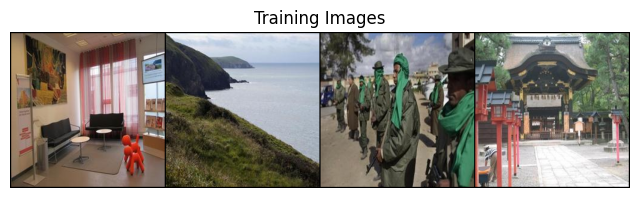

In [5]:
real_batch = next(dl_iter)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# generator for image inpainting, size 256x256
class BigGenerator(nn.Module):
    def __init__(self, ngpu):
        super(BigGenerator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # state size 3x256x256
            nn.Conv2d(num_channels, ngf, kernel_size=5, padding="same", bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size ngf x 256 x 256
            nn.Conv2d(ngf, ngf, kernel_size=3, padding="same", bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size ngf x 256 x 256
            nn.Conv2d(ngf, ngf, kernel_size=3, padding="same", bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size ngf x 256 x 256
            nn.Conv2d(ngf, ngf, kernel_size=3, padding="same", bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size ngf x 256 x 256
            nn.Conv2d(ngf, num_channels, kernel_size=3, padding="same", bias=False),
            nn.Tanh()
            # state size 3 x 256 x 256
        )
    
    def forward(self, input):
        return self.main(input)

In [8]:
class BigDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(BigDiscriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input size 3 x 256 x 256
            nn.Conv2d(num_channels, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size ndf x 128 x 128
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size 1 x 1 x 1
        )
    
    def forward(self, input):
        return self.main(input)

In [9]:
from tqdm.notebook import tqdm

In [10]:
netG2 = BigGenerator(ngpu).to(device)
netG2.apply(weights_init)
print(netG2)

BigGenerator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (13): Tanh()
  )
)


In [11]:
netD2 = BigDiscriminator(ngpu).to(device)
netD2.apply(weights_init)
print(netD2)

BigDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-0

In [13]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of masked images that we will use to visualize
#  the progression of the generator
test_batch = next(dl_iter)[0].to(device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD2 = optim.Adam(netD2.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG2 = optim.Adam(netG2.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [65]:
a = next(iter(dataloader))

In [67]:
a[0].shape

torch.Size([4, 3, 256, 256])

In [83]:
with torch.no_grad():
    o = netD2(a[0].to(device))
    print(o.shape)

torch.Size([4, 1, 1, 1])


In [14]:
from utils.masking import mask_batch

In [25]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(tqdm(dataloader), 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD2.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD2(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of masked images
        masked = mask_batch(real_cpu)
        # Generate fake image batch with G
        fake = netG2(masked)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD2(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD2.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG2.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD2(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG2.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on test_batch
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG2(test_batch).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

[0/100][0/803]	Loss_D: 0.0099	Loss_G: 3.4414	D(x): 0.9982	D(G(z)): 0.0080 / 0.0727
[0/100][50/803]	Loss_D: 1.3059	Loss_G: 4.2411	D(x): 0.4027	D(G(z)): 0.0015 / 0.0248
[0/100][100/803]	Loss_D: 0.0224	Loss_G: 7.8715	D(x): 0.9801	D(G(z)): 0.0021 / 0.0020
[0/100][150/803]	Loss_D: 0.0350	Loss_G: 3.9844	D(x): 0.9860	D(G(z)): 0.0205 / 0.0206
[0/100][200/803]	Loss_D: 0.0017	Loss_G: 8.0164	D(x): 0.9988	D(G(z)): 0.0005 / 0.0005
[0/100][250/803]	Loss_D: 0.0080	Loss_G: 12.0890	D(x): 0.9921	D(G(z)): 0.0000 / 0.0000
[0/100][300/803]	Loss_D: 0.0176	Loss_G: 8.8013	D(x): 0.9833	D(G(z)): 0.0007 / 0.0007
[0/100][350/803]	Loss_D: 0.0034	Loss_G: 9.1368	D(x): 0.9968	D(G(z)): 0.0002 / 0.0002
[0/100][400/803]	Loss_D: 0.0046	Loss_G: 8.3787	D(x): 0.9963	D(G(z)): 0.0009 / 0.0006
[0/100][450/803]	Loss_D: 0.1634	Loss_G: 6.7474	D(x): 0.8688	D(G(z)): 0.0017 / 0.0021
[0/100][500/803]	Loss_D: 0.0015	Loss_G: 7.5743	D(x): 0.9997	D(G(z)): 0.0012 / 0.0012
[0/100][550/803]	Loss_D: 0.0736	Loss_G: 3.5950	D(x): 0.9943	D(G(z))

  0%|          | 0/803 [00:00<?, ?it/s]

[1/100][0/803]	Loss_D: 1.0412	Loss_G: 3.6443	D(x): 0.4477	D(G(z)): 0.0027 / 0.0308
[1/100][50/803]	Loss_D: 0.0289	Loss_G: 5.6173	D(x): 0.9751	D(G(z)): 0.0035 / 0.0040
[1/100][100/803]	Loss_D: 0.0082	Loss_G: 4.9629	D(x): 0.9999	D(G(z)): 0.0081 / 0.0079
[1/100][150/803]	Loss_D: 3.1682	Loss_G: 7.9154	D(x): 0.9998	D(G(z)): 0.9554 / 0.0006
[1/100][200/803]	Loss_D: 0.0778	Loss_G: 8.9621	D(x): 0.9273	D(G(z)): 0.0001 / 0.0001
[1/100][250/803]	Loss_D: 0.0149	Loss_G: 9.3125	D(x): 0.9855	D(G(z)): 0.0002 / 0.0002
[1/100][300/803]	Loss_D: 0.0333	Loss_G: 6.9896	D(x): 0.9695	D(G(z)): 0.0020 / 0.0015
[1/100][350/803]	Loss_D: 0.1571	Loss_G: 11.3821	D(x): 0.8668	D(G(z)): 0.0000 / 0.0000
[1/100][400/803]	Loss_D: 0.0091	Loss_G: 8.1392	D(x): 0.9936	D(G(z)): 0.0027 / 0.0024
[1/100][450/803]	Loss_D: 0.0033	Loss_G: 7.3241	D(x): 0.9976	D(G(z)): 0.0010 / 0.0010
[1/100][500/803]	Loss_D: 7.4414	Loss_G: 6.8503	D(x): 0.9999	D(G(z)): 0.9988 / 0.0039
[1/100][550/803]	Loss_D: 0.0005	Loss_G: 12.9859	D(x): 0.9996	D(G(z)

  0%|          | 0/803 [00:00<?, ?it/s]

[2/100][0/803]	Loss_D: 0.6182	Loss_G: 4.6298	D(x): 0.9996	D(G(z)): 0.3532 / 0.0143
[2/100][50/803]	Loss_D: 0.0515	Loss_G: 4.1327	D(x): 0.9661	D(G(z)): 0.0167 / 0.0170
[2/100][100/803]	Loss_D: 3.6452	Loss_G: 7.7592	D(x): 1.0000	D(G(z)): 0.8727 / 0.0007
[2/100][150/803]	Loss_D: 0.1279	Loss_G: 7.0829	D(x): 0.8809	D(G(z)): 0.0009 / 0.0014
[2/100][200/803]	Loss_D: 0.0537	Loss_G: 5.7325	D(x): 0.9800	D(G(z)): 0.0313 / 0.0199
[2/100][250/803]	Loss_D: 0.0120	Loss_G: 6.0383	D(x): 0.9999	D(G(z)): 0.0117 / 0.0107
[2/100][300/803]	Loss_D: 0.0384	Loss_G: 7.8255	D(x): 0.9631	D(G(z)): 0.0006 / 0.0007
[2/100][350/803]	Loss_D: 0.0372	Loss_G: 4.5281	D(x): 0.9777	D(G(z)): 0.0144 / 0.0119
[2/100][400/803]	Loss_D: 0.0045	Loss_G: 7.4777	D(x): 0.9978	D(G(z)): 0.0023 / 0.0017
[2/100][450/803]	Loss_D: 0.0061	Loss_G: 11.0411	D(x): 0.9939	D(G(z)): 0.0000 / 0.0001
[2/100][500/803]	Loss_D: 0.1803	Loss_G: 5.2680	D(x): 0.8529	D(G(z)): 0.0030 / 0.0058
[2/100][550/803]	Loss_D: 0.0357	Loss_G: 4.5540	D(x): 0.9930	D(G(z))

  0%|          | 0/803 [00:00<?, ?it/s]

[3/100][0/803]	Loss_D: 7.1893	Loss_G: 1.4679	D(x): 1.0000	D(G(z)): 0.9992 / 0.2586
[3/100][50/803]	Loss_D: 0.2314	Loss_G: 9.6566	D(x): 0.8041	D(G(z)): 0.0000 / 0.0001
[3/100][100/803]	Loss_D: 0.3880	Loss_G: 4.1408	D(x): 0.6897	D(G(z)): 0.0074 / 0.0211
[3/100][150/803]	Loss_D: 0.0745	Loss_G: 3.8208	D(x): 0.9993	D(G(z)): 0.0698 / 0.0347
[3/100][200/803]	Loss_D: 0.2473	Loss_G: 11.9615	D(x): 0.8026	D(G(z)): 0.0000 / 0.0000
[3/100][250/803]	Loss_D: 0.0334	Loss_G: 5.6258	D(x): 0.9949	D(G(z)): 0.0268 / 0.0207
[3/100][300/803]	Loss_D: 0.2839	Loss_G: 8.7275	D(x): 0.7773	D(G(z)): 0.0000 / 0.0002
[3/100][350/803]	Loss_D: 0.0234	Loss_G: 6.8913	D(x): 0.9800	D(G(z)): 0.0029 / 0.0033
[3/100][400/803]	Loss_D: 0.0140	Loss_G: 7.5317	D(x): 0.9873	D(G(z)): 0.0011 / 0.0011
[3/100][450/803]	Loss_D: 0.0022	Loss_G: 10.0223	D(x): 0.9980	D(G(z)): 0.0001 / 0.0001
[3/100][500/803]	Loss_D: 2.4334	Loss_G: 2.2408	D(x): 0.1350	D(G(z)): 0.0001 / 0.1659
[3/100][550/803]	Loss_D: 0.0534	Loss_G: 7.6705	D(x): 0.9503	D(G(z)

  0%|          | 0/803 [00:00<?, ?it/s]

[4/100][0/803]	Loss_D: 0.1173	Loss_G: 2.8836	D(x): 0.9979	D(G(z)): 0.1003 / 0.0740
[4/100][50/803]	Loss_D: 0.0388	Loss_G: 4.8287	D(x): 0.9949	D(G(z)): 0.0324 / 0.0194
[4/100][100/803]	Loss_D: 3.5109	Loss_G: 6.9093	D(x): 0.1244	D(G(z)): 0.0000 / 0.0019
[4/100][150/803]	Loss_D: 0.0028	Loss_G: 7.2429	D(x): 0.9993	D(G(z)): 0.0021 / 0.0017
[4/100][200/803]	Loss_D: 0.0016	Loss_G: 8.9638	D(x): 0.9988	D(G(z)): 0.0004 / 0.0003
[4/100][250/803]	Loss_D: 0.0026	Loss_G: 6.5536	D(x): 0.9997	D(G(z)): 0.0023 / 0.0022
[4/100][300/803]	Loss_D: 0.4855	Loss_G: 4.6957	D(x): 0.6902	D(G(z)): 0.0033 / 0.0194
[4/100][350/803]	Loss_D: 0.0022	Loss_G: 8.2023	D(x): 0.9985	D(G(z)): 0.0006 / 0.0007
[4/100][400/803]	Loss_D: 0.0005	Loss_G: 10.6525	D(x): 0.9996	D(G(z)): 0.0002 / 0.0001
[4/100][450/803]	Loss_D: 0.1747	Loss_G: 3.5282	D(x): 0.9998	D(G(z)): 0.1506 / 0.0386
[4/100][500/803]	Loss_D: 0.0790	Loss_G: 4.3718	D(x): 0.9997	D(G(z)): 0.0717 / 0.0167
[4/100][550/803]	Loss_D: 0.0015	Loss_G: 9.2360	D(x): 0.9995	D(G(z))

  0%|          | 0/803 [00:00<?, ?it/s]

[5/100][0/803]	Loss_D: 0.0007	Loss_G: 9.1469	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[5/100][50/803]	Loss_D: 0.0559	Loss_G: 4.5922	D(x): 0.9919	D(G(z)): 0.0462 / 0.0137
[5/100][100/803]	Loss_D: 0.0022	Loss_G: 6.3113	D(x): 0.9997	D(G(z)): 0.0019 / 0.0033
[5/100][150/803]	Loss_D: 0.0245	Loss_G: 7.9932	D(x): 0.9766	D(G(z)): 0.0008 / 0.0007
[5/100][200/803]	Loss_D: 0.5349	Loss_G: 3.3904	D(x): 0.9924	D(G(z)): 0.3837 / 0.0370
[5/100][250/803]	Loss_D: 0.0906	Loss_G: 5.9826	D(x): 0.9647	D(G(z)): 0.0489 / 0.0149
[5/100][300/803]	Loss_D: 0.0144	Loss_G: 6.0543	D(x): 0.9969	D(G(z)): 0.0111 / 0.0102
[5/100][350/803]	Loss_D: 0.0806	Loss_G: 4.6614	D(x): 0.9963	D(G(z)): 0.0686 / 0.0236
[5/100][400/803]	Loss_D: 0.0128	Loss_G: 5.2957	D(x): 0.9999	D(G(z)): 0.0125 / 0.0102
[5/100][450/803]	Loss_D: 0.0095	Loss_G: 6.7916	D(x): 0.9988	D(G(z)): 0.0082 / 0.0061
[5/100][500/803]	Loss_D: 0.0004	Loss_G: 10.5049	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[5/100][550/803]	Loss_D: 0.0038	Loss_G: 11.6655	D(x): 0.9962	D(G(z)

  0%|          | 0/803 [00:00<?, ?it/s]

[6/100][0/803]	Loss_D: 0.0236	Loss_G: 9.0369	D(x): 0.9774	D(G(z)): 0.0002 / 0.0001
[6/100][50/803]	Loss_D: 0.0043	Loss_G: 11.7157	D(x): 0.9957	D(G(z)): 0.0000 / 0.0000
[6/100][100/803]	Loss_D: 0.0066	Loss_G: 6.2553	D(x): 0.9986	D(G(z)): 0.0053 / 0.0046
[6/100][150/803]	Loss_D: 0.0051	Loss_G: 6.0018	D(x): 0.9994	D(G(z)): 0.0045 / 0.0040
[6/100][200/803]	Loss_D: 0.0012	Loss_G: 9.0486	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004
[6/100][250/803]	Loss_D: 1.0083	Loss_G: 8.9338	D(x): 1.0000	D(G(z)): 0.6180 / 0.0002
[6/100][300/803]	Loss_D: 0.3469	Loss_G: 5.9750	D(x): 0.9848	D(G(z)): 0.2324 / 0.0029
[6/100][350/803]	Loss_D: 0.0021	Loss_G: 8.9768	D(x): 0.9987	D(G(z)): 0.0008 / 0.0008
[6/100][400/803]	Loss_D: 0.0158	Loss_G: 5.3868	D(x): 0.9963	D(G(z)): 0.0121 / 0.0058
[6/100][450/803]	Loss_D: 0.0418	Loss_G: 4.0298	D(x): 1.0000	D(G(z)): 0.0405 / 0.0226
[6/100][500/803]	Loss_D: 0.0023	Loss_G: 7.5202	D(x): 0.9994	D(G(z)): 0.0017 / 0.0011
[6/100][550/803]	Loss_D: 0.1056	Loss_G: 3.9209	D(x): 0.9851	D(G(z))

  0%|          | 0/803 [00:00<?, ?it/s]

[7/100][0/803]	Loss_D: 0.3247	Loss_G: 11.7806	D(x): 0.7420	D(G(z)): 0.0000 / 0.0000
[7/100][50/803]	Loss_D: 0.0171	Loss_G: 5.9265	D(x): 0.9941	D(G(z)): 0.0110 / 0.0089
[7/100][100/803]	Loss_D: 4.1752	Loss_G: 9.1210	D(x): 0.9999	D(G(z)): 0.9820 / 0.0002
[7/100][150/803]	Loss_D: 0.1685	Loss_G: 3.6350	D(x): 0.9906	D(G(z)): 0.1431 / 0.0405
[7/100][200/803]	Loss_D: 0.0082	Loss_G: 9.1139	D(x): 0.9927	D(G(z)): 0.0009 / 0.0008
[7/100][250/803]	Loss_D: 0.1615	Loss_G: 9.3792	D(x): 0.8586	D(G(z)): 0.0002 / 0.0003
[7/100][300/803]	Loss_D: 0.0419	Loss_G: 4.3476	D(x): 0.9836	D(G(z)): 0.0246 / 0.0207
[7/100][350/803]	Loss_D: 0.6167	Loss_G: 2.7759	D(x): 0.9997	D(G(z)): 0.4008 / 0.0927
[7/100][400/803]	Loss_D: 0.0330	Loss_G: 8.1422	D(x): 0.9689	D(G(z)): 0.0003 / 0.0003
[7/100][450/803]	Loss_D: 0.0157	Loss_G: 6.4489	D(x): 1.0000	D(G(z)): 0.0152 / 0.0120
[7/100][500/803]	Loss_D: 0.0328	Loss_G: 4.7953	D(x): 0.9946	D(G(z)): 0.0263 / 0.0168
[7/100][550/803]	Loss_D: 0.0003	Loss_G: 10.9394	D(x): 0.9997	D(G(z)

  0%|          | 0/803 [00:00<?, ?it/s]

[8/100][0/803]	Loss_D: 0.0095	Loss_G: 8.5988	D(x): 0.9908	D(G(z)): 0.0002 / 0.0003
[8/100][50/803]	Loss_D: 0.2373	Loss_G: 12.4547	D(x): 0.8176	D(G(z)): 0.0000 / 0.0000
[8/100][100/803]	Loss_D: 0.0017	Loss_G: 9.0723	D(x): 0.9987	D(G(z)): 0.0004 / 0.0002
[8/100][150/803]	Loss_D: 0.0049	Loss_G: 7.4491	D(x): 0.9975	D(G(z)): 0.0024 / 0.0007
[8/100][200/803]	Loss_D: 0.4327	Loss_G: 3.5199	D(x): 0.7706	D(G(z)): 0.1143 / 0.0406
[8/100][250/803]	Loss_D: 0.0063	Loss_G: 7.0254	D(x): 0.9946	D(G(z)): 0.0009 / 0.0016
[8/100][300/803]	Loss_D: 0.0090	Loss_G: 4.6157	D(x): 0.9974	D(G(z)): 0.0064 / 0.0112
[8/100][350/803]	Loss_D: 3.1120	Loss_G: 3.4653	D(x): 0.0684	D(G(z)): 0.0001 / 0.0367
[8/100][400/803]	Loss_D: 0.0007	Loss_G: 8.2674	D(x): 0.9999	D(G(z)): 0.0006 / 0.0014
[8/100][450/803]	Loss_D: 1.7355	Loss_G: 4.1254	D(x): 0.2694	D(G(z)): 0.0001 / 0.0211
[8/100][500/803]	Loss_D: 0.0252	Loss_G: 7.8352	D(x): 0.9766	D(G(z)): 0.0014 / 0.0022
[8/100][550/803]	Loss_D: 0.0097	Loss_G: 8.5243	D(x): 0.9909	D(G(z))

  0%|          | 0/803 [00:00<?, ?it/s]

[9/100][0/803]	Loss_D: 0.0121	Loss_G: 5.6502	D(x): 0.9934	D(G(z)): 0.0055 / 0.0108
[9/100][50/803]	Loss_D: 0.0029	Loss_G: 11.5626	D(x): 0.9971	D(G(z)): 0.0000 / 0.0000
[9/100][100/803]	Loss_D: 0.0003	Loss_G: 10.6695	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[9/100][150/803]	Loss_D: 0.5655	Loss_G: 9.3031	D(x): 0.5744	D(G(z)): 0.0000 / 0.0003
[9/100][200/803]	Loss_D: 0.0003	Loss_G: 11.0047	D(x): 0.9998	D(G(z)): 0.0001 / 0.0000
[9/100][250/803]	Loss_D: 0.2167	Loss_G: 10.8639	D(x): 0.8078	D(G(z)): 0.0000 / 0.0000
[9/100][300/803]	Loss_D: 0.0008	Loss_G: 9.0285	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004
[9/100][350/803]	Loss_D: 0.0009	Loss_G: 7.6534	D(x): 0.9999	D(G(z)): 0.0007 / 0.0014
[9/100][400/803]	Loss_D: 0.0067	Loss_G: 8.5206	D(x): 0.9939	D(G(z)): 0.0006 / 0.0006
[9/100][450/803]	Loss_D: 0.0724	Loss_G: 8.0311	D(x): 0.9325	D(G(z)): 0.0006 / 0.0007
[9/100][500/803]	Loss_D: 0.0020	Loss_G: 7.4665	D(x): 0.9987	D(G(z)): 0.0008 / 0.0008
[9/100][550/803]	Loss_D: 0.1108	Loss_G: 7.4265	D(x): 0.9071	D(G(

  0%|          | 0/803 [00:00<?, ?it/s]

[10/100][0/803]	Loss_D: 0.0162	Loss_G: 4.8386	D(x): 0.9980	D(G(z)): 0.0141 / 0.0107
[10/100][50/803]	Loss_D: 0.0339	Loss_G: 6.9812	D(x): 0.9678	D(G(z)): 0.0009 / 0.0012
[10/100][100/803]	Loss_D: 2.6846	Loss_G: 8.4632	D(x): 0.1233	D(G(z)): 0.0000 / 0.0005
[10/100][150/803]	Loss_D: 0.0009	Loss_G: 9.3790	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001
[10/100][200/803]	Loss_D: 0.0161	Loss_G: 5.2480	D(x): 0.9965	D(G(z)): 0.0124 / 0.0083
[10/100][250/803]	Loss_D: 1.2808	Loss_G: 10.6438	D(x): 0.3744	D(G(z)): 0.0000 / 0.0000
[10/100][300/803]	Loss_D: 0.0101	Loss_G: 5.1896	D(x): 0.9998	D(G(z)): 0.0098 / 0.0082
[10/100][350/803]	Loss_D: 0.0009	Loss_G: 8.6330	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007
[10/100][400/803]	Loss_D: 0.0058	Loss_G: 6.0336	D(x): 0.9999	D(G(z)): 0.0057 / 0.0067
[10/100][450/803]	Loss_D: 0.0831	Loss_G: 4.4850	D(x): 1.0000	D(G(z)): 0.0781 / 0.0130
[10/100][500/803]	Loss_D: 0.1723	Loss_G: 4.1176	D(x): 1.0000	D(G(z)): 0.1502 / 0.0261
[10/100][550/803]	Loss_D: 0.0015	Loss_G: 8.3262	D(x): 0.

  0%|          | 0/803 [00:00<?, ?it/s]

[11/100][0/803]	Loss_D: 0.0167	Loss_G: 9.8661	D(x): 0.9842	D(G(z)): 0.0008 / 0.0006
[11/100][50/803]	Loss_D: 0.4211	Loss_G: 3.8554	D(x): 1.0000	D(G(z)): 0.3038 / 0.0264
[11/100][100/803]	Loss_D: 0.0124	Loss_G: 9.5419	D(x): 0.9881	D(G(z)): 0.0003 / 0.0003
[11/100][150/803]	Loss_D: 0.0623	Loss_G: 4.1807	D(x): 0.9665	D(G(z)): 0.0275 / 0.0197
[11/100][200/803]	Loss_D: 0.7482	Loss_G: 7.8602	D(x): 1.0000	D(G(z)): 0.4548 / 0.0006
[11/100][250/803]	Loss_D: 0.5870	Loss_G: 15.7142	D(x): 0.5721	D(G(z)): 0.0000 / 0.0000
[11/100][300/803]	Loss_D: 0.2622	Loss_G: 7.6882	D(x): 1.0000	D(G(z)): 0.1656 / 0.0013
[11/100][350/803]	Loss_D: 0.0149	Loss_G: 4.7561	D(x): 0.9999	D(G(z)): 0.0147 / 0.0118
[11/100][400/803]	Loss_D: 0.0072	Loss_G: 5.7583	D(x): 1.0000	D(G(z)): 0.0071 / 0.0080
[11/100][450/803]	Loss_D: 0.1420	Loss_G: 5.1125	D(x): 0.9999	D(G(z)): 0.1294 / 0.0087
[11/100][500/803]	Loss_D: 0.0189	Loss_G: 4.8385	D(x): 0.9970	D(G(z)): 0.0157 / 0.0110
[11/100][550/803]	Loss_D: 0.0015	Loss_G: 8.1081	D(x): 1.

  0%|          | 0/803 [00:00<?, ?it/s]

[12/100][0/803]	Loss_D: 0.8627	Loss_G: 3.8275	D(x): 1.0000	D(G(z)): 0.5282 / 0.0285
[12/100][50/803]	Loss_D: 0.0006	Loss_G: 8.1261	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[12/100][100/803]	Loss_D: 0.0003	Loss_G: 10.2751	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[12/100][150/803]	Loss_D: 0.7678	Loss_G: 4.2645	D(x): 1.0000	D(G(z)): 0.3816 / 0.0199
[12/100][200/803]	Loss_D: 0.3333	Loss_G: 5.4746	D(x): 0.9983	D(G(z)): 0.2499 / 0.0091
[12/100][250/803]	Loss_D: 1.3037	Loss_G: 6.5809	D(x): 0.4415	D(G(z)): 0.0012 / 0.0025
[12/100][300/803]	Loss_D: 0.0038	Loss_G: 7.4278	D(x): 0.9999	D(G(z)): 0.0037 / 0.0021
[12/100][350/803]	Loss_D: 0.0021	Loss_G: 8.2012	D(x): 0.9990	D(G(z)): 0.0010 / 0.0006
[12/100][400/803]	Loss_D: 0.0063	Loss_G: 6.5400	D(x): 1.0000	D(G(z)): 0.0062 / 0.0059
[12/100][450/803]	Loss_D: 0.0006	Loss_G: 8.2014	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[12/100][500/803]	Loss_D: 0.0109	Loss_G: 8.4797	D(x): 0.9896	D(G(z)): 0.0004 / 0.0004
[12/100][550/803]	Loss_D: 0.0177	Loss_G: 11.8031	D(x): 0

  0%|          | 0/803 [00:00<?, ?it/s]

[13/100][0/803]	Loss_D: 1.7956	Loss_G: 7.9943	D(x): 0.9998	D(G(z)): 0.7723 / 0.0005
[13/100][50/803]	Loss_D: 0.0127	Loss_G: 8.4456	D(x): 0.9881	D(G(z)): 0.0006 / 0.0004
[13/100][100/803]	Loss_D: 0.1296	Loss_G: 4.0319	D(x): 0.9994	D(G(z)): 0.1187 / 0.0196
[13/100][150/803]	Loss_D: 0.1616	Loss_G: 5.5353	D(x): 0.8618	D(G(z)): 0.0072 / 0.0089
[13/100][200/803]	Loss_D: 0.0666	Loss_G: 3.5761	D(x): 0.9985	D(G(z)): 0.0602 / 0.0755
[13/100][250/803]	Loss_D: 0.0056	Loss_G: 6.5462	D(x): 0.9971	D(G(z)): 0.0026 / 0.0025
[13/100][300/803]	Loss_D: 0.0106	Loss_G: 10.0060	D(x): 0.9905	D(G(z)): 0.0010 / 0.0010
[13/100][350/803]	Loss_D: 0.0015	Loss_G: 7.6412	D(x): 0.9992	D(G(z)): 0.0007 / 0.0007
[13/100][400/803]	Loss_D: 0.0729	Loss_G: 3.9849	D(x): 0.9898	D(G(z)): 0.0590 / 0.0290
[13/100][450/803]	Loss_D: 0.0070	Loss_G: 5.3412	D(x): 0.9999	D(G(z)): 0.0069 / 0.0060
[13/100][500/803]	Loss_D: 0.0057	Loss_G: 6.0063	D(x): 1.0000	D(G(z)): 0.0056 / 0.0046
[13/100][550/803]	Loss_D: 0.0035	Loss_G: 6.7341	D(x): 0.

  0%|          | 0/803 [00:00<?, ?it/s]

[14/100][0/803]	Loss_D: 0.1578	Loss_G: 1.8589	D(x): 1.0000	D(G(z)): 0.1315 / 0.1643
[14/100][50/803]	Loss_D: 0.0025	Loss_G: 11.0204	D(x): 0.9976	D(G(z)): 0.0000 / 0.0000
[14/100][100/803]	Loss_D: 0.2337	Loss_G: 4.4509	D(x): 0.9989	D(G(z)): 0.1810 / 0.0125
[14/100][150/803]	Loss_D: 1.6434	Loss_G: 6.0792	D(x): 0.9999	D(G(z)): 0.7467 / 0.0029
[14/100][200/803]	Loss_D: 0.0009	Loss_G: 10.3486	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[14/100][250/803]	Loss_D: 0.0329	Loss_G: 5.0388	D(x): 0.9940	D(G(z)): 0.0262 / 0.0129
[14/100][300/803]	Loss_D: 0.0151	Loss_G: 6.1194	D(x): 0.9951	D(G(z)): 0.0101 / 0.0092
[14/100][350/803]	Loss_D: 0.0011	Loss_G: 13.9912	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[14/100][400/803]	Loss_D: 4.6169	Loss_G: 1.9496	D(x): 0.0131	D(G(z)): 0.0004 / 0.2520
[14/100][450/803]	Loss_D: 0.4810	Loss_G: 6.2697	D(x): 0.9999	D(G(z)): 0.2241 / 0.0103
[14/100][500/803]	Loss_D: 0.0540	Loss_G: 4.9967	D(x): 0.9997	D(G(z)): 0.0515 / 0.0084
[14/100][550/803]	Loss_D: 0.0010	Loss_G: 9.3141	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[15/100][0/803]	Loss_D: 0.0628	Loss_G: 7.2152	D(x): 0.9425	D(G(z)): 0.0016 / 0.0019
[15/100][50/803]	Loss_D: 0.5191	Loss_G: 5.1967	D(x): 0.9998	D(G(z)): 0.3402 / 0.0075
[15/100][100/803]	Loss_D: 0.0017	Loss_G: 9.5293	D(x): 0.9984	D(G(z)): 0.0001 / 0.0001
[15/100][150/803]	Loss_D: 0.0033	Loss_G: 8.4823	D(x): 0.9969	D(G(z)): 0.0002 / 0.0003
[15/100][200/803]	Loss_D: 0.0047	Loss_G: 5.5192	D(x): 0.9999	D(G(z)): 0.0046 / 0.0043
[15/100][250/803]	Loss_D: 0.0005	Loss_G: 9.2857	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[15/100][300/803]	Loss_D: 0.0018	Loss_G: 7.2048	D(x): 0.9992	D(G(z)): 0.0009 / 0.0009
[15/100][350/803]	Loss_D: 0.4314	Loss_G: 7.7781	D(x): 0.9950	D(G(z)): 0.3060 / 0.0005
[15/100][400/803]	Loss_D: 0.1117	Loss_G: 4.5016	D(x): 0.9978	D(G(z)): 0.0988 / 0.0175
[15/100][450/803]	Loss_D: 0.3354	Loss_G: 6.9923	D(x): 0.7603	D(G(z)): 0.0003 / 0.0012
[15/100][500/803]	Loss_D: 0.0086	Loss_G: 10.7040	D(x): 0.9915	D(G(z)): 0.0001 / 0.0001
[15/100][550/803]	Loss_D: 0.3422	Loss_G: 9.5433	D(x): 0.

  0%|          | 0/803 [00:00<?, ?it/s]

[16/100][0/803]	Loss_D: 0.0059	Loss_G: 7.5705	D(x): 0.9956	D(G(z)): 0.0015 / 0.0006
[16/100][50/803]	Loss_D: 0.0220	Loss_G: 7.7630	D(x): 0.9791	D(G(z)): 0.0005 / 0.0007
[16/100][100/803]	Loss_D: 0.2606	Loss_G: 4.6399	D(x): 0.9990	D(G(z)): 0.2107 / 0.0110
[16/100][150/803]	Loss_D: 0.0058	Loss_G: 6.3083	D(x): 0.9964	D(G(z)): 0.0022 / 0.0022
[16/100][200/803]	Loss_D: 0.0072	Loss_G: 6.1076	D(x): 0.9999	D(G(z)): 0.0070 / 0.0061
[16/100][250/803]	Loss_D: 0.0010	Loss_G: 7.1749	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[16/100][300/803]	Loss_D: 0.0941	Loss_G: 12.7129	D(x): 0.9119	D(G(z)): 0.0000 / 0.0000
[16/100][350/803]	Loss_D: 0.0236	Loss_G: 10.2954	D(x): 0.9770	D(G(z)): 0.0000 / 0.0001
[16/100][400/803]	Loss_D: 0.0006	Loss_G: 7.5573	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[16/100][450/803]	Loss_D: 0.0001	Loss_G: 11.5457	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[16/100][500/803]	Loss_D: 0.2008	Loss_G: 9.0913	D(x): 1.0000	D(G(z)): 0.1696 / 0.0005
[16/100][550/803]	Loss_D: 0.0008	Loss_G: 8.2530	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[17/100][0/803]	Loss_D: 0.0060	Loss_G: 12.5726	D(x): 0.9940	D(G(z)): 0.0000 / 0.0000
[17/100][50/803]	Loss_D: 0.0015	Loss_G: 10.0162	D(x): 0.9986	D(G(z)): 0.0001 / 0.0001
[17/100][100/803]	Loss_D: 0.0017	Loss_G: 11.0604	D(x): 0.9985	D(G(z)): 0.0002 / 0.0002
[17/100][150/803]	Loss_D: 1.0595	Loss_G: 5.2331	D(x): 0.4041	D(G(z)): 0.0001 / 0.0067
[17/100][200/803]	Loss_D: 0.4173	Loss_G: 4.1461	D(x): 0.9647	D(G(z)): 0.2854 / 0.0177
[17/100][250/803]	Loss_D: 0.0720	Loss_G: 5.9849	D(x): 0.9340	D(G(z)): 0.0031 / 0.0041
[17/100][300/803]	Loss_D: 0.0431	Loss_G: 6.1114	D(x): 0.9621	D(G(z)): 0.0041 / 0.0040
[17/100][350/803]	Loss_D: 0.0032	Loss_G: 7.0606	D(x): 0.9988	D(G(z)): 0.0020 / 0.0018
[17/100][400/803]	Loss_D: 0.0670	Loss_G: 10.2603	D(x): 0.9362	D(G(z)): 0.0002 / 0.0002
[17/100][450/803]	Loss_D: 0.0042	Loss_G: 6.5735	D(x): 0.9999	D(G(z)): 0.0041 / 0.0037
[17/100][500/803]	Loss_D: 0.0337	Loss_G: 9.7408	D(x): 0.9673	D(G(z)): 0.0001 / 0.0001
[17/100][550/803]	Loss_D: 0.0337	Loss_G: 7.9712	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[18/100][0/803]	Loss_D: 0.0505	Loss_G: 4.8611	D(x): 1.0000	D(G(z)): 0.0475 / 0.0168
[18/100][50/803]	Loss_D: 0.0014	Loss_G: 8.0510	D(x): 0.9993	D(G(z)): 0.0007 / 0.0005
[18/100][100/803]	Loss_D: 0.0183	Loss_G: 5.4475	D(x): 1.0000	D(G(z)): 0.0178 / 0.0128
[18/100][150/803]	Loss_D: 0.0000	Loss_G: 11.8970	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/100][200/803]	Loss_D: 0.5190	Loss_G: 11.5181	D(x): 0.6573	D(G(z)): 0.0000 / 0.0000
[18/100][250/803]	Loss_D: 0.0015	Loss_G: 6.9408	D(x): 0.9999	D(G(z)): 0.0014 / 0.0013
[18/100][300/803]	Loss_D: 0.3383	Loss_G: 7.1148	D(x): 0.9999	D(G(z)): 0.2797 / 0.0009
[18/100][350/803]	Loss_D: 0.0016	Loss_G: 6.8764	D(x): 0.9997	D(G(z)): 0.0013 / 0.0012
[18/100][400/803]	Loss_D: 0.0111	Loss_G: 5.7198	D(x): 1.0000	D(G(z)): 0.0109 / 0.0093
[18/100][450/803]	Loss_D: 0.0008	Loss_G: 9.6585	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[18/100][500/803]	Loss_D: 0.0115	Loss_G: 4.2333	D(x): 0.9992	D(G(z)): 0.0106 / 0.0197
[18/100][550/803]	Loss_D: 0.7274	Loss_G: 9.2757	D(x): 1

  0%|          | 0/803 [00:00<?, ?it/s]

[19/100][0/803]	Loss_D: 0.0028	Loss_G: 6.7291	D(x): 0.9999	D(G(z)): 0.0026 / 0.0020
[19/100][50/803]	Loss_D: 0.0009	Loss_G: 9.9435	D(x): 0.9996	D(G(z)): 0.0005 / 0.0001
[19/100][100/803]	Loss_D: 0.0051	Loss_G: 6.7732	D(x): 0.9965	D(G(z)): 0.0016 / 0.0015
[19/100][150/803]	Loss_D: 0.0003	Loss_G: 8.5594	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[19/100][200/803]	Loss_D: 0.0035	Loss_G: 7.6023	D(x): 1.0000	D(G(z)): 0.0035 / 0.0033
[19/100][250/803]	Loss_D: 0.0002	Loss_G: 12.6178	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[19/100][300/803]	Loss_D: 0.0002	Loss_G: 9.1290	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[19/100][350/803]	Loss_D: 0.0009	Loss_G: 8.5135	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004
[19/100][400/803]	Loss_D: 0.1325	Loss_G: 4.5428	D(x): 1.0000	D(G(z)): 0.1201 / 0.0140
[19/100][450/803]	Loss_D: 0.0176	Loss_G: 5.0520	D(x): 0.9943	D(G(z)): 0.0118 / 0.0120
[19/100][500/803]	Loss_D: 0.0324	Loss_G: 10.0568	D(x): 0.9685	D(G(z)): 0.0002 / 0.0003
[19/100][550/803]	Loss_D: 0.1640	Loss_G: 6.6934	D(x): 0

  0%|          | 0/803 [00:00<?, ?it/s]

[20/100][0/803]	Loss_D: 0.0029	Loss_G: 7.2034	D(x): 0.9987	D(G(z)): 0.0016 / 0.0015
[20/100][50/803]	Loss_D: 0.0012	Loss_G: 8.0883	D(x): 0.9996	D(G(z)): 0.0007 / 0.0008
[20/100][100/803]	Loss_D: 0.1963	Loss_G: 8.3529	D(x): 0.8262	D(G(z)): 0.0003 / 0.0004
[20/100][150/803]	Loss_D: 3.1833	Loss_G: 6.1901	D(x): 0.9994	D(G(z)): 0.9508 / 0.0039
[20/100][200/803]	Loss_D: 0.3573	Loss_G: 10.2136	D(x): 0.7726	D(G(z)): 0.0000 / 0.0001
[20/100][250/803]	Loss_D: 0.0012	Loss_G: 8.4159	D(x): 0.9993	D(G(z)): 0.0005 / 0.0005
[20/100][300/803]	Loss_D: 0.0103	Loss_G: 5.1423	D(x): 0.9998	D(G(z)): 0.0100 / 0.0079
[20/100][350/803]	Loss_D: 0.0015	Loss_G: 9.9781	D(x): 0.9997	D(G(z)): 0.0013 / 0.0012
[20/100][400/803]	Loss_D: 0.0014	Loss_G: 8.0728	D(x): 1.0000	D(G(z)): 0.0014 / 0.0014
[20/100][450/803]	Loss_D: 0.0175	Loss_G: 6.0577	D(x): 0.9860	D(G(z)): 0.0033 / 0.0027
[20/100][500/803]	Loss_D: 0.0090	Loss_G: 11.4489	D(x): 0.9911	D(G(z)): 0.0000 / 0.0000
[20/100][550/803]	Loss_D: 0.0490	Loss_G: 10.2795	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[21/100][0/803]	Loss_D: 0.0093	Loss_G: 3.2185	D(x): 0.9973	D(G(z)): 0.0066 / 0.0527
[21/100][50/803]	Loss_D: 0.0001	Loss_G: 12.2593	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[21/100][100/803]	Loss_D: 2.2598	Loss_G: 3.7012	D(x): 0.9992	D(G(z)): 0.4989 / 0.1705
[21/100][150/803]	Loss_D: 0.5434	Loss_G: 8.2300	D(x): 0.6502	D(G(z)): 0.0002 / 0.0006
[21/100][200/803]	Loss_D: 0.0903	Loss_G: 4.5072	D(x): 0.9309	D(G(z)): 0.0168 / 0.0158
[21/100][250/803]	Loss_D: 0.0010	Loss_G: 7.3519	D(x): 0.9998	D(G(z)): 0.0008 / 0.0007
[21/100][300/803]	Loss_D: 0.0400	Loss_G: 9.5239	D(x): 0.9614	D(G(z)): 0.0001 / 0.0001
[21/100][350/803]	Loss_D: 0.0151	Loss_G: 4.4793	D(x): 0.9986	D(G(z)): 0.0135 / 0.0175
[21/100][400/803]	Loss_D: 0.0028	Loss_G: 13.8736	D(x): 0.9972	D(G(z)): 0.0000 / 0.0000
[21/100][450/803]	Loss_D: 0.0068	Loss_G: 4.8929	D(x): 1.0000	D(G(z)): 0.0067 / 0.0116
[21/100][500/803]	Loss_D: 0.0308	Loss_G: 9.3566	D(x): 0.9703	D(G(z)): 0.0001 / 0.0001
[21/100][550/803]	Loss_D: 0.0083	Loss_G: 7.2227	D(x): 0

  0%|          | 0/803 [00:00<?, ?it/s]

[22/100][0/803]	Loss_D: 0.0000	Loss_G: 12.9912	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[22/100][50/803]	Loss_D: 0.0032	Loss_G: 6.3948	D(x): 0.9998	D(G(z)): 0.0029 / 0.0022
[22/100][100/803]	Loss_D: 0.0010	Loss_G: 7.7143	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007
[22/100][150/803]	Loss_D: 0.0041	Loss_G: 11.2021	D(x): 0.9959	D(G(z)): 0.0000 / 0.0000
[22/100][200/803]	Loss_D: 0.0000	Loss_G: 14.5834	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[22/100][250/803]	Loss_D: 0.0021	Loss_G: 7.8457	D(x): 0.9988	D(G(z)): 0.0009 / 0.0009
[22/100][300/803]	Loss_D: 0.4007	Loss_G: 8.7289	D(x): 0.7040	D(G(z)): 0.0000 / 0.0005
[22/100][350/803]	Loss_D: 0.0000	Loss_G: 21.1856	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[22/100][400/803]	Loss_D: 0.0024	Loss_G: 13.6541	D(x): 0.9976	D(G(z)): 0.0000 / 0.0000
[22/100][450/803]	Loss_D: 0.3441	Loss_G: 5.3811	D(x): 0.7520	D(G(z)): 0.0014 / 0.0062
[22/100][500/803]	Loss_D: 0.0010	Loss_G: 8.2002	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005
[22/100][550/803]	Loss_D: 0.0154	Loss_G: 10.1260	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[23/100][0/803]	Loss_D: 0.0002	Loss_G: 12.3353	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[23/100][50/803]	Loss_D: 0.0027	Loss_G: 7.7615	D(x): 0.9987	D(G(z)): 0.0014 / 0.0013
[23/100][100/803]	Loss_D: 0.0106	Loss_G: 7.1393	D(x): 0.9907	D(G(z)): 0.0013 / 0.0013
[23/100][150/803]	Loss_D: 0.0692	Loss_G: 7.7626	D(x): 0.9342	D(G(z)): 0.0008 / 0.0009
[23/100][200/803]	Loss_D: 0.0016	Loss_G: 8.0918	D(x): 0.9989	D(G(z)): 0.0004 / 0.0004
[23/100][250/803]	Loss_D: 1.4459	Loss_G: 10.8715	D(x): 1.0000	D(G(z)): 0.6394 / 0.0000
[23/100][300/803]	Loss_D: 0.0001	Loss_G: 10.1479	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[23/100][350/803]	Loss_D: 0.0005	Loss_G: 9.2816	D(x): 0.9998	D(G(z)): 0.0003 / 0.0004
[23/100][400/803]	Loss_D: 0.0070	Loss_G: 10.7836	D(x): 0.9932	D(G(z)): 0.0002 / 0.0002
[23/100][450/803]	Loss_D: 0.0222	Loss_G: 4.7586	D(x): 1.0000	D(G(z)): 0.0216 / 0.0147
[23/100][500/803]	Loss_D: 0.6798	Loss_G: 5.5095	D(x): 0.5648	D(G(z)): 0.0001 / 0.0057
[23/100][550/803]	Loss_D: 0.0003	Loss_G: 12.8625	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[24/100][0/803]	Loss_D: 0.0020	Loss_G: 12.1964	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[24/100][50/803]	Loss_D: 0.0011	Loss_G: 7.1741	D(x): 1.0000	D(G(z)): 0.0011 / 0.0010
[24/100][100/803]	Loss_D: 0.0001	Loss_G: 12.9331	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[24/100][150/803]	Loss_D: 0.0023	Loss_G: 17.2690	D(x): 0.9977	D(G(z)): 0.0000 / 0.0000
[24/100][200/803]	Loss_D: 0.0032	Loss_G: 15.3965	D(x): 0.9968	D(G(z)): 0.0000 / 0.0000
[24/100][250/803]	Loss_D: 0.0913	Loss_G: 4.8825	D(x): 1.0000	D(G(z)): 0.0798 / 0.0126
[24/100][300/803]	Loss_D: 0.2442	Loss_G: 8.0761	D(x): 0.8189	D(G(z)): 0.0021 / 0.0050
[24/100][350/803]	Loss_D: 0.0510	Loss_G: 5.6490	D(x): 0.9956	D(G(z)): 0.0447 / 0.0045
[24/100][400/803]	Loss_D: 0.0611	Loss_G: 10.6752	D(x): 0.9419	D(G(z)): 0.0000 / 0.0001
[24/100][450/803]	Loss_D: 0.0002	Loss_G: 9.7181	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[24/100][500/803]	Loss_D: 0.0023	Loss_G: 9.0375	D(x): 0.9979	D(G(z)): 0.0001 / 0.0001
[24/100][550/803]	Loss_D: 0.0110	Loss_G: 4.9387	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[25/100][0/803]	Loss_D: 0.1256	Loss_G: 11.0507	D(x): 0.8851	D(G(z)): 0.0000 / 0.0000
[25/100][50/803]	Loss_D: 3.0143	Loss_G: 6.5094	D(x): 0.0868	D(G(z)): 0.0000 / 0.0020
[25/100][100/803]	Loss_D: 0.0001	Loss_G: 10.0963	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[25/100][150/803]	Loss_D: 0.0007	Loss_G: 9.6001	D(x): 0.9995	D(G(z)): 0.0002 / 0.0003
[25/100][200/803]	Loss_D: 0.4320	Loss_G: 7.1837	D(x): 1.0000	D(G(z)): 0.3152 / 0.0009
[25/100][250/803]	Loss_D: 0.0295	Loss_G: 5.9620	D(x): 0.9802	D(G(z)): 0.0090 / 0.0086
[25/100][300/803]	Loss_D: 0.0067	Loss_G: 6.1190	D(x): 0.9998	D(G(z)): 0.0065 / 0.0057
[25/100][350/803]	Loss_D: 0.0005	Loss_G: 7.9458	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[25/100][400/803]	Loss_D: 0.0004	Loss_G: 9.2679	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[25/100][450/803]	Loss_D: 0.0095	Loss_G: 11.5907	D(x): 0.9907	D(G(z)): 0.0000 / 0.0000
[25/100][500/803]	Loss_D: 0.0033	Loss_G: 9.0299	D(x): 0.9977	D(G(z)): 0.0011 / 0.0011
[25/100][550/803]	Loss_D: 0.0002	Loss_G: 15.4034	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[26/100][0/803]	Loss_D: 0.0001	Loss_G: 11.2178	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[26/100][50/803]	Loss_D: 0.0650	Loss_G: 11.5034	D(x): 0.9396	D(G(z)): 0.0001 / 0.0001
[26/100][100/803]	Loss_D: 0.0253	Loss_G: 3.7489	D(x): 1.0000	D(G(z)): 0.0248 / 0.0325
[26/100][150/803]	Loss_D: 0.0029	Loss_G: 9.3268	D(x): 0.9972	D(G(z)): 0.0001 / 0.0001
[26/100][200/803]	Loss_D: 0.0217	Loss_G: 7.7423	D(x): 1.0000	D(G(z)): 0.0208 / 0.0107
[26/100][250/803]	Loss_D: 0.0014	Loss_G: 9.8242	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002
[26/100][300/803]	Loss_D: 0.0004	Loss_G: 8.2866	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[26/100][350/803]	Loss_D: 0.0162	Loss_G: 11.2536	D(x): 0.9841	D(G(z)): 0.0001 / 0.0001
[26/100][400/803]	Loss_D: 0.0003	Loss_G: 10.2936	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[26/100][450/803]	Loss_D: 2.2113	Loss_G: 7.2304	D(x): 0.1946	D(G(z)): 0.0000 / 0.0019
[26/100][500/803]	Loss_D: 0.0003	Loss_G: 10.5527	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[26/100][550/803]	Loss_D: 0.0345	Loss_G: 5.6473	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[27/100][0/803]	Loss_D: 0.0389	Loss_G: 10.5096	D(x): 0.9623	D(G(z)): 0.0002 / 0.0002
[27/100][50/803]	Loss_D: 0.0008	Loss_G: 9.6967	D(x): 0.9993	D(G(z)): 0.0002 / 0.0001
[27/100][100/803]	Loss_D: 0.0097	Loss_G: 5.2891	D(x): 0.9979	D(G(z)): 0.0076 / 0.0091
[27/100][150/803]	Loss_D: 0.6703	Loss_G: 11.8213	D(x): 0.6335	D(G(z)): 0.0000 / 0.0000
[27/100][200/803]	Loss_D: 0.0024	Loss_G: 8.7339	D(x): 0.9986	D(G(z)): 0.0010 / 0.0009
[27/100][250/803]	Loss_D: 0.0355	Loss_G: 4.9218	D(x): 0.9995	D(G(z)): 0.0342 / 0.0089
[27/100][300/803]	Loss_D: 0.0006	Loss_G: 7.5912	D(x): 1.0000	D(G(z)): 0.0005 / 0.0017
[27/100][350/803]	Loss_D: 0.0157	Loss_G: 5.1461	D(x): 0.9999	D(G(z)): 0.0154 / 0.0115
[27/100][400/803]	Loss_D: 1.8269	Loss_G: 4.8099	D(x): 0.1830	D(G(z)): 0.0000 / 0.0171
[27/100][450/803]	Loss_D: 0.2168	Loss_G: 11.2704	D(x): 0.8146	D(G(z)): 0.0000 / 0.0000
[27/100][500/803]	Loss_D: 0.0009	Loss_G: 9.8800	D(x): 0.9993	D(G(z)): 0.0002 / 0.0003
[27/100][550/803]	Loss_D: 0.0011	Loss_G: 12.3292	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[28/100][0/803]	Loss_D: 0.0346	Loss_G: 8.3124	D(x): 0.9677	D(G(z)): 0.0010 / 0.0012
[28/100][50/803]	Loss_D: 0.0051	Loss_G: 5.7580	D(x): 1.0000	D(G(z)): 0.0051 / 0.0048
[28/100][100/803]	Loss_D: 0.0003	Loss_G: 9.4504	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[28/100][150/803]	Loss_D: 0.0029	Loss_G: 6.5397	D(x): 0.9998	D(G(z)): 0.0027 / 0.0021
[28/100][200/803]	Loss_D: 0.1357	Loss_G: 12.8765	D(x): 0.8766	D(G(z)): 0.0000 / 0.0000
[28/100][250/803]	Loss_D: 0.0008	Loss_G: 9.2141	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[28/100][300/803]	Loss_D: 0.0021	Loss_G: 7.0426	D(x): 1.0000	D(G(z)): 0.0020 / 0.0019
[28/100][350/803]	Loss_D: 0.0000	Loss_G: 10.8183	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[28/100][400/803]	Loss_D: 0.0012	Loss_G: 8.3521	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004
[28/100][450/803]	Loss_D: 0.0029	Loss_G: 7.6096	D(x): 0.9999	D(G(z)): 0.0028 / 0.0024
[28/100][500/803]	Loss_D: 0.0001	Loss_G: 11.1276	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[28/100][550/803]	Loss_D: 0.0246	Loss_G: 7.0005	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[29/100][0/803]	Loss_D: 4.0788	Loss_G: 6.1874	D(x): 1.0000	D(G(z)): 0.9622 / 0.0043
[29/100][50/803]	Loss_D: 0.0009	Loss_G: 13.0458	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[29/100][100/803]	Loss_D: 0.0004	Loss_G: 9.3357	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[29/100][150/803]	Loss_D: 0.0191	Loss_G: 6.8849	D(x): 0.9835	D(G(z)): 0.0023 / 0.0025
[29/100][200/803]	Loss_D: 0.7065	Loss_G: 7.3477	D(x): 0.9696	D(G(z)): 0.4574 / 0.0008
[29/100][250/803]	Loss_D: 0.0011	Loss_G: 7.3428	D(x): 1.0000	D(G(z)): 0.0011 / 0.0011
[29/100][300/803]	Loss_D: 0.0044	Loss_G: 10.0250	D(x): 0.9957	D(G(z)): 0.0001 / 0.0001
[29/100][350/803]	Loss_D: 0.0019	Loss_G: 7.0122	D(x): 0.9999	D(G(z)): 0.0017 / 0.0013
[29/100][400/803]	Loss_D: 2.8920	Loss_G: 10.5050	D(x): 0.9991	D(G(z)): 0.8269 / 0.0001
[29/100][450/803]	Loss_D: 0.3270	Loss_G: 3.2339	D(x): 0.7379	D(G(z)): 0.0036 / 0.0461
[29/100][500/803]	Loss_D: 0.0074	Loss_G: 6.8876	D(x): 0.9975	D(G(z)): 0.0049 / 0.0046
[29/100][550/803]	Loss_D: 0.0011	Loss_G: 7.1280	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[30/100][0/803]	Loss_D: 0.0018	Loss_G: 6.9155	D(x): 0.9998	D(G(z)): 0.0016 / 0.0015
[30/100][50/803]	Loss_D: 0.4480	Loss_G: 7.9441	D(x): 0.8359	D(G(z)): 0.2211 / 0.0004
[30/100][100/803]	Loss_D: 0.0379	Loss_G: 8.2729	D(x): 0.9638	D(G(z)): 0.0004 / 0.0004
[30/100][150/803]	Loss_D: 0.0024	Loss_G: 6.6857	D(x): 0.9997	D(G(z)): 0.0021 / 0.0018
[30/100][200/803]	Loss_D: 0.0611	Loss_G: 5.1738	D(x): 0.9481	D(G(z)): 0.0043 / 0.0064
[30/100][250/803]	Loss_D: 0.0444	Loss_G: 5.2984	D(x): 0.9826	D(G(z)): 0.0257 / 0.0137
[30/100][300/803]	Loss_D: 0.0267	Loss_G: 7.4492	D(x): 0.9757	D(G(z)): 0.0013 / 0.0012
[30/100][350/803]	Loss_D: 0.0018	Loss_G: 12.5979	D(x): 0.9982	D(G(z)): 0.0000 / 0.0000
[30/100][400/803]	Loss_D: 0.0027	Loss_G: 6.9975	D(x): 0.9987	D(G(z)): 0.0014 / 0.0012
[30/100][450/803]	Loss_D: 0.0482	Loss_G: 12.3595	D(x): 0.9553	D(G(z)): 0.0000 / 0.0000
[30/100][500/803]	Loss_D: 0.0003	Loss_G: 9.5335	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[30/100][550/803]	Loss_D: 0.2974	Loss_G: 6.9924	D(x): 0

  0%|          | 0/803 [00:00<?, ?it/s]

[31/100][0/803]	Loss_D: 0.3068	Loss_G: 5.2132	D(x): 1.0000	D(G(z)): 0.2319 / 0.0077
[31/100][50/803]	Loss_D: 0.0010	Loss_G: 7.0544	D(x): 1.0000	D(G(z)): 0.0010 / 0.0009
[31/100][100/803]	Loss_D: 0.0011	Loss_G: 8.1557	D(x): 0.9999	D(G(z)): 0.0010 / 0.0008
[31/100][150/803]	Loss_D: 0.0178	Loss_G: 7.8914	D(x): 0.9836	D(G(z)): 0.0011 / 0.0011
[31/100][200/803]	Loss_D: 0.1242	Loss_G: 3.6143	D(x): 0.9992	D(G(z)): 0.1145 / 0.0288
[31/100][250/803]	Loss_D: 0.0001	Loss_G: 12.7389	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[31/100][300/803]	Loss_D: 0.0001	Loss_G: 13.0882	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[31/100][350/803]	Loss_D: 0.0028	Loss_G: 13.4001	D(x): 0.9972	D(G(z)): 0.0000 / 0.0000
[31/100][400/803]	Loss_D: 0.0144	Loss_G: 4.7156	D(x): 0.9996	D(G(z)): 0.0137 / 0.0236
[31/100][450/803]	Loss_D: 0.0710	Loss_G: 3.2374	D(x): 0.9882	D(G(z)): 0.0567 / 0.0441
[31/100][500/803]	Loss_D: 0.0106	Loss_G: 11.9148	D(x): 0.9896	D(G(z)): 0.0000 / 0.0000
[31/100][550/803]	Loss_D: 0.0006	Loss_G: 8.3501	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[32/100][0/803]	Loss_D: 0.6174	Loss_G: 8.0328	D(x): 0.6490	D(G(z)): 0.0000 / 0.0014
[32/100][50/803]	Loss_D: 0.0001	Loss_G: 10.2056	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[32/100][100/803]	Loss_D: 0.0007	Loss_G: 9.6878	D(x): 0.9997	D(G(z)): 0.0004 / 0.0002
[32/100][150/803]	Loss_D: 0.0024	Loss_G: 8.2082	D(x): 0.9999	D(G(z)): 0.0023 / 0.0022
[32/100][200/803]	Loss_D: 0.0054	Loss_G: 6.1293	D(x): 0.9978	D(G(z)): 0.0032 / 0.0029
[32/100][250/803]	Loss_D: 0.0012	Loss_G: 7.2758	D(x): 1.0000	D(G(z)): 0.0012 / 0.0011
[32/100][300/803]	Loss_D: 0.0211	Loss_G: 5.1181	D(x): 0.9999	D(G(z)): 0.0205 / 0.0108
[32/100][350/803]	Loss_D: 0.2649	Loss_G: 5.3660	D(x): 0.9999	D(G(z)): 0.2215 / 0.0057
[32/100][400/803]	Loss_D: 0.0015	Loss_G: 6.7445	D(x): 1.0000	D(G(z)): 0.0014 / 0.0013
[32/100][450/803]	Loss_D: 0.0024	Loss_G: 7.4649	D(x): 0.9997	D(G(z)): 0.0021 / 0.0027
[32/100][500/803]	Loss_D: 0.0001	Loss_G: 11.2181	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[32/100][550/803]	Loss_D: 0.0017	Loss_G: 7.4468	D(x): 1

  0%|          | 0/803 [00:00<?, ?it/s]

[33/100][0/803]	Loss_D: 0.1619	Loss_G: 4.7095	D(x): 0.9814	D(G(z)): 0.1149 / 0.0162
[33/100][50/803]	Loss_D: 0.0062	Loss_G: 10.0861	D(x): 0.9939	D(G(z)): 0.0001 / 0.0001
[33/100][100/803]	Loss_D: 0.0231	Loss_G: 5.8868	D(x): 0.9997	D(G(z)): 0.0221 / 0.0164
[33/100][150/803]	Loss_D: 0.0582	Loss_G: 9.8920	D(x): 0.9450	D(G(z)): 0.0002 / 0.0001
[33/100][200/803]	Loss_D: 0.0593	Loss_G: 7.4913	D(x): 0.9935	D(G(z)): 0.0478 / 0.0036
[33/100][250/803]	Loss_D: 0.0056	Loss_G: 5.4717	D(x): 0.9994	D(G(z)): 0.0050 / 0.0047
[33/100][300/803]	Loss_D: 0.0231	Loss_G: 12.6661	D(x): 0.9773	D(G(z)): 0.0000 / 0.0000
[33/100][350/803]	Loss_D: 0.0630	Loss_G: 10.5100	D(x): 0.9403	D(G(z)): 0.0002 / 0.0002
[33/100][400/803]	Loss_D: 0.0005	Loss_G: 10.0835	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[33/100][450/803]	Loss_D: 0.0580	Loss_G: 14.5549	D(x): 0.9445	D(G(z)): 0.0000 / 0.0000
[33/100][500/803]	Loss_D: 0.0041	Loss_G: 4.3460	D(x): 0.9997	D(G(z)): 0.0038 / 0.0169
[33/100][550/803]	Loss_D: 0.0013	Loss_G: 7.8189	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[34/100][0/803]	Loss_D: 0.0150	Loss_G: 12.7978	D(x): 0.9854	D(G(z)): 0.0000 / 0.0000
[34/100][50/803]	Loss_D: 0.0071	Loss_G: 5.8596	D(x): 1.0000	D(G(z)): 0.0070 / 0.0067
[34/100][100/803]	Loss_D: 0.3877	Loss_G: 5.3073	D(x): 0.9988	D(G(z)): 0.2914 / 0.0094
[34/100][150/803]	Loss_D: 0.0008	Loss_G: 6.9210	D(x): 1.0000	D(G(z)): 0.0008 / 0.0012
[34/100][200/803]	Loss_D: 0.0016	Loss_G: 8.7398	D(x): 0.9999	D(G(z)): 0.0015 / 0.0011
[34/100][250/803]	Loss_D: 0.1208	Loss_G: 4.2743	D(x): 0.9262	D(G(z)): 0.0396 / 0.0267
[34/100][300/803]	Loss_D: 0.1886	Loss_G: 13.4135	D(x): 0.8629	D(G(z)): 0.0000 / 0.0000
[34/100][350/803]	Loss_D: 0.0004	Loss_G: 11.2290	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[34/100][400/803]	Loss_D: 0.0001	Loss_G: 10.3808	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[34/100][450/803]	Loss_D: 0.2013	Loss_G: 5.5618	D(x): 1.0000	D(G(z)): 0.1643 / 0.0245
[34/100][500/803]	Loss_D: 0.0000	Loss_G: 14.1296	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[34/100][550/803]	Loss_D: 0.0904	Loss_G: 4.9546	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[35/100][0/803]	Loss_D: 0.1791	Loss_G: 5.2768	D(x): 1.0000	D(G(z)): 0.1415 / 0.0092
[35/100][50/803]	Loss_D: 0.0110	Loss_G: 9.4370	D(x): 0.9893	D(G(z)): 0.0001 / 0.0001
[35/100][100/803]	Loss_D: 0.0263	Loss_G: 6.2331	D(x): 0.9999	D(G(z)): 0.0249 / 0.0149
[35/100][150/803]	Loss_D: 0.1629	Loss_G: 4.2678	D(x): 0.9995	D(G(z)): 0.1368 / 0.0178
[35/100][200/803]	Loss_D: 0.7402	Loss_G: 7.5500	D(x): 0.9998	D(G(z)): 0.4644 / 0.0008
[35/100][250/803]	Loss_D: 0.0045	Loss_G: 9.6400	D(x): 0.9957	D(G(z)): 0.0001 / 0.0002
[35/100][300/803]	Loss_D: 0.0029	Loss_G: 6.4418	D(x): 0.9995	D(G(z)): 0.0024 / 0.0024
[35/100][350/803]	Loss_D: 0.0223	Loss_G: 5.8615	D(x): 1.0000	D(G(z)): 0.0218 / 0.0134
[35/100][400/803]	Loss_D: 0.1852	Loss_G: 5.6478	D(x): 0.8500	D(G(z)): 0.0010 / 0.0058
[35/100][450/803]	Loss_D: 0.4268	Loss_G: 2.7759	D(x): 0.9968	D(G(z)): 0.2162 / 0.1058
[35/100][500/803]	Loss_D: 0.5236	Loss_G: 2.9145	D(x): 1.0000	D(G(z)): 0.3531 / 0.0710
[35/100][550/803]	Loss_D: 1.2093	Loss_G: 8.7698	D(x): 1.0

  0%|          | 0/803 [00:00<?, ?it/s]

[36/100][0/803]	Loss_D: 0.0048	Loss_G: 4.0921	D(x): 0.9999	D(G(z)): 0.0047 / 0.0199
[36/100][50/803]	Loss_D: 0.0289	Loss_G: 4.4847	D(x): 0.9929	D(G(z)): 0.0215 / 0.0164
[36/100][100/803]	Loss_D: 2.0966	Loss_G: 11.3699	D(x): 0.1341	D(G(z)): 0.0000 / 0.0000
[36/100][150/803]	Loss_D: 5.7989	Loss_G: 3.1182	D(x): 1.0000	D(G(z)): 0.9953 / 0.0510
[36/100][200/803]	Loss_D: 0.0693	Loss_G: 4.2898	D(x): 0.9996	D(G(z)): 0.0653 / 0.0183
[36/100][250/803]	Loss_D: 0.1214	Loss_G: 3.2743	D(x): 0.9999	D(G(z)): 0.1134 / 0.0393
[36/100][300/803]	Loss_D: 0.0009	Loss_G: 7.4158	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008
[36/100][350/803]	Loss_D: 0.0057	Loss_G: 6.6716	D(x): 0.9999	D(G(z)): 0.0055 / 0.0051
[36/100][400/803]	Loss_D: 0.0009	Loss_G: 8.8462	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005
[36/100][450/803]	Loss_D: 0.0041	Loss_G: 7.8010	D(x): 0.9969	D(G(z)): 0.0010 / 0.0010
[36/100][500/803]	Loss_D: 0.1538	Loss_G: 5.3641	D(x): 1.0000	D(G(z)): 0.1286 / 0.0148
[36/100][550/803]	Loss_D: 0.0017	Loss_G: 6.7900	D(x): 1.

  0%|          | 0/803 [00:00<?, ?it/s]

[37/100][0/803]	Loss_D: 0.0033	Loss_G: 10.5460	D(x): 0.9968	D(G(z)): 0.0001 / 0.0001
[37/100][50/803]	Loss_D: 0.0006	Loss_G: 9.7007	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[37/100][100/803]	Loss_D: 0.0007	Loss_G: 8.0543	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005
[37/100][150/803]	Loss_D: 0.6930	Loss_G: 6.3351	D(x): 0.5750	D(G(z)): 0.0016 / 0.0194
[37/100][200/803]	Loss_D: 0.0016	Loss_G: 7.7534	D(x): 0.9997	D(G(z)): 0.0013 / 0.0012
[37/100][250/803]	Loss_D: 0.0004	Loss_G: 8.8338	D(x): 0.9997	D(G(z)): 0.0001 / 0.0003
[37/100][300/803]	Loss_D: 0.0213	Loss_G: 4.7348	D(x): 0.9995	D(G(z)): 0.0204 / 0.0118
[37/100][350/803]	Loss_D: 0.0004	Loss_G: 8.2736	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[37/100][400/803]	Loss_D: 0.0001	Loss_G: 10.1902	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[37/100][450/803]	Loss_D: 0.0004	Loss_G: 14.8574	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[37/100][500/803]	Loss_D: 0.1945	Loss_G: 8.9591	D(x): 0.8278	D(G(z)): 0.0001 / 0.0002
[37/100][550/803]	Loss_D: 0.0209	Loss_G: 6.0242	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[38/100][0/803]	Loss_D: 0.3514	Loss_G: 8.2269	D(x): 0.7385	D(G(z)): 0.0001 / 0.0006
[38/100][50/803]	Loss_D: 0.0066	Loss_G: 6.2182	D(x): 0.9999	D(G(z)): 0.0064 / 0.0059
[38/100][100/803]	Loss_D: 0.1165	Loss_G: 13.4558	D(x): 0.8947	D(G(z)): 0.0000 / 0.0000
[38/100][150/803]	Loss_D: 0.1500	Loss_G: 8.5470	D(x): 0.8820	D(G(z)): 0.0001 / 0.0004
[38/100][200/803]	Loss_D: 0.0029	Loss_G: 6.6291	D(x): 1.0000	D(G(z)): 0.0029 / 0.0047
[38/100][250/803]	Loss_D: 0.0095	Loss_G: 5.2132	D(x): 1.0000	D(G(z)): 0.0094 / 0.0077
[38/100][300/803]	Loss_D: 0.0073	Loss_G: 6.4385	D(x): 0.9989	D(G(z)): 0.0061 / 0.0061
[38/100][350/803]	Loss_D: 0.0001	Loss_G: 9.8650	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[38/100][400/803]	Loss_D: 0.0061	Loss_G: 7.0827	D(x): 0.9956	D(G(z)): 0.0017 / 0.0017
[38/100][450/803]	Loss_D: 0.0002	Loss_G: 10.0670	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[38/100][500/803]	Loss_D: 0.0028	Loss_G: 9.8346	D(x): 0.9977	D(G(z)): 0.0005 / 0.0008
[38/100][550/803]	Loss_D: 0.0096	Loss_G: 6.0175	D(x): 0

  0%|          | 0/803 [00:00<?, ?it/s]

[39/100][0/803]	Loss_D: 0.0007	Loss_G: 10.2818	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[39/100][50/803]	Loss_D: 0.0000	Loss_G: 11.6371	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[39/100][100/803]	Loss_D: 0.0042	Loss_G: 5.5725	D(x): 1.0000	D(G(z)): 0.0042 / 0.0039
[39/100][150/803]	Loss_D: 0.0961	Loss_G: 4.4503	D(x): 1.0000	D(G(z)): 0.0892 / 0.0312
[39/100][200/803]	Loss_D: 0.4056	Loss_G: 5.9113	D(x): 0.6879	D(G(z)): 0.0003 / 0.0035
[39/100][250/803]	Loss_D: 0.0021	Loss_G: 13.9633	D(x): 0.9979	D(G(z)): 0.0000 / 0.0000
[39/100][300/803]	Loss_D: 0.0138	Loss_G: 11.6623	D(x): 0.9864	D(G(z)): 0.0000 / 0.0000
[39/100][350/803]	Loss_D: 0.0337	Loss_G: 13.8806	D(x): 0.9681	D(G(z)): 0.0000 / 0.0000
[39/100][400/803]	Loss_D: 0.0073	Loss_G: 12.2969	D(x): 0.9928	D(G(z)): 0.0000 / 0.0000
[39/100][450/803]	Loss_D: 0.0707	Loss_G: 7.4989	D(x): 0.9332	D(G(z)): 0.0007 / 0.0008
[39/100][500/803]	Loss_D: 0.0005	Loss_G: 11.3509	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[39/100][550/803]	Loss_D: 0.0002	Loss_G: 10.7629	D

  0%|          | 0/803 [00:00<?, ?it/s]

[40/100][0/803]	Loss_D: 0.0006	Loss_G: 11.9603	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[40/100][50/803]	Loss_D: 0.0052	Loss_G: 9.5227	D(x): 0.9951	D(G(z)): 0.0003 / 0.0002
[40/100][100/803]	Loss_D: 2.7228	Loss_G: 9.3092	D(x): 1.0000	D(G(z)): 0.8074 / 0.0002
[40/100][150/803]	Loss_D: 1.3832	Loss_G: 7.2370	D(x): 0.4948	D(G(z)): 0.0039 / 0.0043
[40/100][200/803]	Loss_D: 3.2172	Loss_G: 11.3299	D(x): 0.9999	D(G(z)): 0.9098 / 0.0000
[40/100][250/803]	Loss_D: 0.0083	Loss_G: 7.0807	D(x): 0.9999	D(G(z)): 0.0081 / 0.0071
[40/100][300/803]	Loss_D: 0.0165	Loss_G: 8.8821	D(x): 0.9840	D(G(z)): 0.0002 / 0.0002
[40/100][350/803]	Loss_D: 0.0048	Loss_G: 10.0116	D(x): 0.9953	D(G(z)): 0.0001 / 0.0001
[40/100][400/803]	Loss_D: 0.0020	Loss_G: 11.8451	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[40/100][450/803]	Loss_D: 0.0004	Loss_G: 12.1617	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[40/100][500/803]	Loss_D: 0.1641	Loss_G: 12.9806	D(x): 0.8528	D(G(z)): 0.0000 / 0.0000
[40/100][550/803]	Loss_D: 0.0318	Loss_G: 6.8138	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[41/100][0/803]	Loss_D: 0.0008	Loss_G: 8.9073	D(x): 0.9995	D(G(z)): 0.0003 / 0.0007
[41/100][50/803]	Loss_D: 2.2130	Loss_G: 0.4652	D(x): 0.1850	D(G(z)): 0.0236 / 0.6848
[41/100][100/803]	Loss_D: 0.0370	Loss_G: 11.7970	D(x): 0.9638	D(G(z)): 0.0001 / 0.0001
[41/100][150/803]	Loss_D: 0.1806	Loss_G: 4.3112	D(x): 0.9999	D(G(z)): 0.1440 / 0.0234
[41/100][200/803]	Loss_D: 1.0472	Loss_G: 7.4063	D(x): 0.4157	D(G(z)): 0.0000 / 0.0018
[41/100][250/803]	Loss_D: 0.0381	Loss_G: 4.1429	D(x): 0.9993	D(G(z)): 0.0359 / 0.0265
[41/100][300/803]	Loss_D: 0.0064	Loss_G: 6.3240	D(x): 0.9970	D(G(z)): 0.0034 / 0.0033
[41/100][350/803]	Loss_D: 0.0203	Loss_G: 6.6680	D(x): 0.9911	D(G(z)): 0.0111 / 0.0102
[41/100][400/803]	Loss_D: 0.8598	Loss_G: 7.3921	D(x): 0.5908	D(G(z)): 0.0011 / 0.0025
[41/100][450/803]	Loss_D: 0.0084	Loss_G: 5.7702	D(x): 0.9994	D(G(z)): 0.0078 / 0.0060
[41/100][500/803]	Loss_D: 0.0281	Loss_G: 4.8445	D(x): 0.9998	D(G(z)): 0.0267 / 0.0191
[41/100][550/803]	Loss_D: 0.0783	Loss_G: 6.4948	D(x): 0.

  0%|          | 0/803 [00:00<?, ?it/s]

[42/100][0/803]	Loss_D: 0.0022	Loss_G: 13.2349	D(x): 0.9978	D(G(z)): 0.0000 / 0.0000
[42/100][50/803]	Loss_D: 0.0096	Loss_G: 5.4686	D(x): 0.9999	D(G(z)): 0.0095 / 0.0064
[42/100][100/803]	Loss_D: 0.0003	Loss_G: 12.3653	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[42/100][150/803]	Loss_D: 0.0001	Loss_G: 11.3635	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[42/100][200/803]	Loss_D: 0.0004	Loss_G: 13.8327	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[42/100][250/803]	Loss_D: 0.0005	Loss_G: 8.0322	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[42/100][300/803]	Loss_D: 0.0007	Loss_G: 14.1792	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[42/100][350/803]	Loss_D: 0.0023	Loss_G: 6.9793	D(x): 1.0000	D(G(z)): 0.0023 / 0.0021
[42/100][400/803]	Loss_D: 0.0003	Loss_G: 9.3180	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[42/100][450/803]	Loss_D: 0.0006	Loss_G: 9.2666	D(x): 0.9999	D(G(z)): 0.0005 / 0.0004
[42/100][500/803]	Loss_D: 0.0000	Loss_G: 13.2570	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[42/100][550/803]	Loss_D: 0.0001	Loss_G: 13.2590	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[43/100][0/803]	Loss_D: 0.0005	Loss_G: 9.7019	D(x): 0.9998	D(G(z)): 0.0003 / 0.0001
[43/100][50/803]	Loss_D: 0.0000	Loss_G: 12.7125	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[43/100][100/803]	Loss_D: 0.9318	Loss_G: 12.8157	D(x): 1.0000	D(G(z)): 0.4919 / 0.0000
[43/100][150/803]	Loss_D: 0.0008	Loss_G: 11.8505	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[43/100][200/803]	Loss_D: 0.0014	Loss_G: 7.5047	D(x): 0.9998	D(G(z)): 0.0012 / 0.0008
[43/100][250/803]	Loss_D: 0.0043	Loss_G: 6.7539	D(x): 0.9988	D(G(z)): 0.0031 / 0.0032
[43/100][300/803]	Loss_D: 0.0051	Loss_G: 6.5002	D(x): 0.9999	D(G(z)): 0.0050 / 0.0033
[43/100][350/803]	Loss_D: 0.0015	Loss_G: 8.5304	D(x): 0.9991	D(G(z)): 0.0005 / 0.0005
[43/100][400/803]	Loss_D: 0.0036	Loss_G: 6.4202	D(x): 0.9998	D(G(z)): 0.0033 / 0.0032
[43/100][450/803]	Loss_D: 0.2241	Loss_G: 6.0074	D(x): 0.8230	D(G(z)): 0.0015 / 0.0043
[43/100][500/803]	Loss_D: 0.0000	Loss_G: 11.9254	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[43/100][550/803]	Loss_D: 0.0002	Loss_G: 9.7903	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[44/100][0/803]	Loss_D: 0.0549	Loss_G: 2.9913	D(x): 1.0000	D(G(z)): 0.0523 / 0.0691
[44/100][50/803]	Loss_D: 0.0022	Loss_G: 6.9042	D(x): 0.9999	D(G(z)): 0.0021 / 0.0017
[44/100][100/803]	Loss_D: 0.0006	Loss_G: 9.4835	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[44/100][150/803]	Loss_D: 0.0167	Loss_G: 8.5699	D(x): 0.9838	D(G(z)): 0.0003 / 0.0003
[44/100][200/803]	Loss_D: 0.0045	Loss_G: 5.9778	D(x): 1.0000	D(G(z)): 0.0044 / 0.0037
[44/100][250/803]	Loss_D: 0.0009	Loss_G: 11.9415	D(x): 0.9992	D(G(z)): 0.0001 / 0.0000
[44/100][300/803]	Loss_D: 0.0098	Loss_G: 5.5680	D(x): 0.9973	D(G(z)): 0.0071 / 0.0064
[44/100][350/803]	Loss_D: 0.0000	Loss_G: 11.1959	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[44/100][400/803]	Loss_D: 0.0003	Loss_G: 9.2060	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[44/100][450/803]	Loss_D: 0.0016	Loss_G: 11.3600	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[44/100][500/803]	Loss_D: 0.0025	Loss_G: 6.6432	D(x): 1.0000	D(G(z)): 0.0025 / 0.0024
[44/100][550/803]	Loss_D: 0.0019	Loss_G: 11.0810	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[45/100][0/803]	Loss_D: 0.0026	Loss_G: 6.2267	D(x): 0.9999	D(G(z)): 0.0025 / 0.0024
[45/100][50/803]	Loss_D: 3.0245	Loss_G: 4.1803	D(x): 0.6623	D(G(z)): 0.7219 / 0.0236
[45/100][100/803]	Loss_D: 0.0007	Loss_G: 8.3334	D(x): 0.9998	D(G(z)): 0.0004 / 0.0007
[45/100][150/803]	Loss_D: 0.0004	Loss_G: 13.5069	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[45/100][200/803]	Loss_D: 0.1122	Loss_G: 13.2452	D(x): 0.9016	D(G(z)): 0.0000 / 0.0000
[45/100][250/803]	Loss_D: 0.0001	Loss_G: 16.3192	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[45/100][300/803]	Loss_D: 0.1252	Loss_G: 5.0965	D(x): 0.9997	D(G(z)): 0.1099 / 0.0102
[45/100][350/803]	Loss_D: 0.0010	Loss_G: 14.5917	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000
[45/100][400/803]	Loss_D: 0.0040	Loss_G: 6.0045	D(x): 0.9999	D(G(z)): 0.0039 / 0.0037
[45/100][450/803]	Loss_D: 0.0031	Loss_G: 7.5859	D(x): 0.9999	D(G(z)): 0.0030 / 0.0029
[45/100][500/803]	Loss_D: 0.0460	Loss_G: 5.0549	D(x): 1.0000	D(G(z)): 0.0441 / 0.0149
[45/100][550/803]	Loss_D: 0.0016	Loss_G: 6.6823	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[46/100][0/803]	Loss_D: 0.0024	Loss_G: 5.7301	D(x): 1.0000	D(G(z)): 0.0024 / 0.0135
[46/100][50/803]	Loss_D: 0.0466	Loss_G: 7.7294	D(x): 0.9574	D(G(z)): 0.0009 / 0.0010
[46/100][100/803]	Loss_D: 0.0002	Loss_G: 12.0475	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[46/100][150/803]	Loss_D: 0.0192	Loss_G: 4.7882	D(x): 0.9965	D(G(z)): 0.0155 / 0.0143
[46/100][200/803]	Loss_D: 0.2554	Loss_G: 12.0962	D(x): 0.7793	D(G(z)): 0.0000 / 0.0000
[46/100][250/803]	Loss_D: 0.0333	Loss_G: 4.7558	D(x): 0.9973	D(G(z)): 0.0297 / 0.0176
[46/100][300/803]	Loss_D: 0.0101	Loss_G: 14.2244	D(x): 0.9900	D(G(z)): 0.0000 / 0.0000
[46/100][350/803]	Loss_D: 0.0020	Loss_G: 5.2498	D(x): 1.0000	D(G(z)): 0.0020 / 0.0057
[46/100][400/803]	Loss_D: 0.0357	Loss_G: 4.3783	D(x): 0.9920	D(G(z)): 0.0270 / 0.0185
[46/100][450/803]	Loss_D: 0.0061	Loss_G: 11.6471	D(x): 0.9939	D(G(z)): 0.0000 / 0.0000
[46/100][500/803]	Loss_D: 0.0166	Loss_G: 9.3155	D(x): 0.9845	D(G(z)): 0.0009 / 0.0008
[46/100][550/803]	Loss_D: 0.0000	Loss_G: 12.6913	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[47/100][0/803]	Loss_D: 1.2135	Loss_G: 8.6385	D(x): 1.0000	D(G(z)): 0.5505 / 0.0003
[47/100][50/803]	Loss_D: 0.0642	Loss_G: 4.6696	D(x): 0.9999	D(G(z)): 0.0604 / 0.0205
[47/100][100/803]	Loss_D: 0.0236	Loss_G: 18.1186	D(x): 0.9768	D(G(z)): 0.0000 / 0.0000
[47/100][150/803]	Loss_D: 0.0006	Loss_G: 14.0482	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[47/100][200/803]	Loss_D: 0.0000	Loss_G: 12.7588	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[47/100][250/803]	Loss_D: 0.0085	Loss_G: 8.4802	D(x): 0.9918	D(G(z)): 0.0003 / 0.0004
[47/100][300/803]	Loss_D: 0.0053	Loss_G: 6.1637	D(x): 0.9982	D(G(z)): 0.0035 / 0.0042
[47/100][350/803]	Loss_D: 0.0003	Loss_G: 10.3988	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[47/100][400/803]	Loss_D: 0.0194	Loss_G: 9.3235	D(x): 0.9814	D(G(z)): 0.0002 / 0.0002
[47/100][450/803]	Loss_D: 0.0004	Loss_G: 8.9552	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[47/100][500/803]	Loss_D: 0.1719	Loss_G: 7.7159	D(x): 0.8623	D(G(z)): 0.0006 / 0.0011
[47/100][550/803]	Loss_D: 0.0019	Loss_G: 7.5168	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[48/100][0/803]	Loss_D: 0.0003	Loss_G: 11.7284	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[48/100][50/803]	Loss_D: 0.0014	Loss_G: 7.7530	D(x): 0.9998	D(G(z)): 0.0012 / 0.0012
[48/100][100/803]	Loss_D: 0.0130	Loss_G: 9.4546	D(x): 0.9874	D(G(z)): 0.0001 / 0.0001
[48/100][150/803]	Loss_D: 0.0334	Loss_G: 4.2664	D(x): 1.0000	D(G(z)): 0.0328 / 0.0142
[48/100][200/803]	Loss_D: 0.0008	Loss_G: 8.3590	D(x): 0.9998	D(G(z)): 0.0006 / 0.0007
[48/100][250/803]	Loss_D: 0.0006	Loss_G: 8.1057	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005
[48/100][300/803]	Loss_D: 0.0332	Loss_G: 5.6172	D(x): 0.9999	D(G(z)): 0.0318 / 0.0080
[48/100][350/803]	Loss_D: 0.0013	Loss_G: 9.5921	D(x): 0.9995	D(G(z)): 0.0008 / 0.0007
[48/100][400/803]	Loss_D: 0.0030	Loss_G: 6.2156	D(x): 0.9998	D(G(z)): 0.0028 / 0.0025
[48/100][450/803]	Loss_D: 0.0230	Loss_G: 12.7365	D(x): 0.9774	D(G(z)): 0.0000 / 0.0000
[48/100][500/803]	Loss_D: 0.0540	Loss_G: 4.4135	D(x): 0.9989	D(G(z)): 0.0505 / 0.0198
[48/100][550/803]	Loss_D: 0.0006	Loss_G: 7.8107	D(x): 1

  0%|          | 0/803 [00:00<?, ?it/s]

[49/100][0/803]	Loss_D: 0.0949	Loss_G: 1.0575	D(x): 0.9995	D(G(z)): 0.0896 / 0.3508
[49/100][50/803]	Loss_D: 0.2702	Loss_G: 5.3915	D(x): 1.0000	D(G(z)): 0.2196 / 0.0067
[49/100][100/803]	Loss_D: 0.0035	Loss_G: 6.3841	D(x): 1.0000	D(G(z)): 0.0035 / 0.0033
[49/100][150/803]	Loss_D: 0.0010	Loss_G: 7.7906	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007
[49/100][200/803]	Loss_D: 0.0508	Loss_G: 4.8733	D(x): 0.9993	D(G(z)): 0.0467 / 0.0187
[49/100][250/803]	Loss_D: 0.0020	Loss_G: 8.7189	D(x): 0.9983	D(G(z)): 0.0004 / 0.0003
[49/100][300/803]	Loss_D: 0.0070	Loss_G: 6.3423	D(x): 1.0000	D(G(z)): 0.0069 / 0.0072
[49/100][350/803]	Loss_D: 0.0001	Loss_G: 9.8685	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[49/100][400/803]	Loss_D: 0.0011	Loss_G: 8.6761	D(x): 0.9996	D(G(z)): 0.0008 / 0.0008
[49/100][450/803]	Loss_D: 0.0001	Loss_G: 10.6281	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[49/100][500/803]	Loss_D: 0.0049	Loss_G: 7.4571	D(x): 0.9987	D(G(z)): 0.0035 / 0.0029
[49/100][550/803]	Loss_D: 0.0120	Loss_G: 16.4754	D(x): 0

  0%|          | 0/803 [00:00<?, ?it/s]

[50/100][0/803]	Loss_D: 0.0223	Loss_G: 7.5426	D(x): 0.9829	D(G(z)): 0.0049 / 0.0093
[50/100][50/803]	Loss_D: 0.0004	Loss_G: 10.5947	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[50/100][100/803]	Loss_D: 0.0027	Loss_G: 10.0569	D(x): 0.9974	D(G(z)): 0.0001 / 0.0001
[50/100][150/803]	Loss_D: 0.0005	Loss_G: 10.2088	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[50/100][200/803]	Loss_D: 0.0011	Loss_G: 12.5720	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[50/100][250/803]	Loss_D: 0.0009	Loss_G: 7.7167	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[50/100][300/803]	Loss_D: 0.0006	Loss_G: 9.5607	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003
[50/100][350/803]	Loss_D: 0.1007	Loss_G: 4.7646	D(x): 0.9975	D(G(z)): 0.0903 / 0.0115
[50/100][400/803]	Loss_D: 0.0043	Loss_G: 7.0705	D(x): 0.9986	D(G(z)): 0.0029 / 0.0028
[50/100][450/803]	Loss_D: 0.0002	Loss_G: 9.9015	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[50/100][500/803]	Loss_D: 0.0018	Loss_G: 6.5776	D(x): 1.0000	D(G(z)): 0.0018 / 0.0017
[50/100][550/803]	Loss_D: 0.0366	Loss_G: 4.1539	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[51/100][0/803]	Loss_D: 0.8194	Loss_G: 8.8866	D(x): 0.7173	D(G(z)): 0.0005 / 0.0005
[51/100][50/803]	Loss_D: 0.1439	Loss_G: 6.1348	D(x): 0.8757	D(G(z)): 0.0014 / 0.0032
[51/100][100/803]	Loss_D: 0.7166	Loss_G: 8.8563	D(x): 0.5485	D(G(z)): 0.0000 / 0.0003
[51/100][150/803]	Loss_D: 0.0001	Loss_G: 12.1621	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[51/100][200/803]	Loss_D: 0.0004	Loss_G: 9.1205	D(x): 1.0000	D(G(z)): 0.0004 / 0.0001
[51/100][250/803]	Loss_D: 0.0002	Loss_G: 13.6522	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[51/100][300/803]	Loss_D: 0.7202	Loss_G: 6.8486	D(x): 0.9995	D(G(z)): 0.4424 / 0.0011
[51/100][350/803]	Loss_D: 0.0027	Loss_G: 9.8013	D(x): 0.9974	D(G(z)): 0.0002 / 0.0002
[51/100][400/803]	Loss_D: 0.0039	Loss_G: 7.4551	D(x): 1.0000	D(G(z)): 0.0039 / 0.0020
[51/100][450/803]	Loss_D: 0.0010	Loss_G: 13.3557	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000
[51/100][500/803]	Loss_D: 0.1518	Loss_G: 12.6937	D(x): 0.8611	D(G(z)): 0.0000 / 0.0000
[51/100][550/803]	Loss_D: 0.1279	Loss_G: 5.7060	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[52/100][0/803]	Loss_D: 0.5261	Loss_G: 4.5173	D(x): 0.9997	D(G(z)): 0.3644 / 0.0112
[52/100][50/803]	Loss_D: 0.0008	Loss_G: 7.2796	D(x): 1.0000	D(G(z)): 0.0008 / 0.0010
[52/100][100/803]	Loss_D: 0.0248	Loss_G: 10.4730	D(x): 0.9757	D(G(z)): 0.0000 / 0.0000
[52/100][150/803]	Loss_D: 0.2164	Loss_G: 11.1614	D(x): 0.8459	D(G(z)): 0.0000 / 0.0001
[52/100][200/803]	Loss_D: 1.3812	Loss_G: 5.2320	D(x): 1.0000	D(G(z)): 0.6898 / 0.0057
[52/100][250/803]	Loss_D: 0.0019	Loss_G: 7.6727	D(x): 0.9999	D(G(z)): 0.0018 / 0.0012
[52/100][300/803]	Loss_D: 0.0050	Loss_G: 6.4521	D(x): 0.9999	D(G(z)): 0.0049 / 0.0042
[52/100][350/803]	Loss_D: 0.0167	Loss_G: 4.6853	D(x): 0.9989	D(G(z)): 0.0154 / 0.0127
[52/100][400/803]	Loss_D: 0.0001	Loss_G: 10.4307	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[52/100][450/803]	Loss_D: 0.0015	Loss_G: 12.7574	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000
[52/100][500/803]	Loss_D: 0.0017	Loss_G: 12.6000	D(x): 0.9983	D(G(z)): 0.0000 / 0.0000
[52/100][550/803]	Loss_D: 2.4392	Loss_G: 14.8006	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[53/100][0/803]	Loss_D: 0.9883	Loss_G: 10.2967	D(x): 0.4755	D(G(z)): 0.0000 / 0.0001
[53/100][50/803]	Loss_D: 0.0068	Loss_G: 6.4274	D(x): 0.9982	D(G(z)): 0.0049 / 0.0060
[53/100][100/803]	Loss_D: 0.0895	Loss_G: 13.3460	D(x): 0.9168	D(G(z)): 0.0000 / 0.0000
[53/100][150/803]	Loss_D: 0.0005	Loss_G: 8.6579	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[53/100][200/803]	Loss_D: 0.0027	Loss_G: 6.5404	D(x): 0.9994	D(G(z)): 0.0021 / 0.0020
[53/100][250/803]	Loss_D: 0.0013	Loss_G: 10.0891	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001
[53/100][300/803]	Loss_D: 0.0012	Loss_G: 7.9298	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011
[53/100][350/803]	Loss_D: 0.0011	Loss_G: 9.4787	D(x): 0.9990	D(G(z)): 0.0001 / 0.0001
[53/100][400/803]	Loss_D: 0.0021	Loss_G: 9.1657	D(x): 0.9983	D(G(z)): 0.0004 / 0.0004
[53/100][450/803]	Loss_D: 0.0008	Loss_G: 9.7934	D(x): 0.9996	D(G(z)): 0.0004 / 0.0003
[53/100][500/803]	Loss_D: 0.0002	Loss_G: 9.3048	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[53/100][550/803]	Loss_D: 0.0003	Loss_G: 12.3435	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[54/100][0/803]	Loss_D: 0.0008	Loss_G: 7.1670	D(x): 1.0000	D(G(z)): 0.0008 / 0.0009
[54/100][50/803]	Loss_D: 0.1152	Loss_G: 8.9999	D(x): 0.8928	D(G(z)): 0.0001 / 0.0002
[54/100][100/803]	Loss_D: 0.0009	Loss_G: 8.7297	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006
[54/100][150/803]	Loss_D: 0.0007	Loss_G: 10.7992	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[54/100][200/803]	Loss_D: 0.0004	Loss_G: 11.8855	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[54/100][250/803]	Loss_D: 0.0016	Loss_G: 8.2898	D(x): 0.9994	D(G(z)): 0.0010 / 0.0010
[54/100][300/803]	Loss_D: 0.0000	Loss_G: 13.3646	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[54/100][350/803]	Loss_D: 0.7350	Loss_G: 6.7772	D(x): 0.5117	D(G(z)): 0.0000 / 0.0020
[54/100][400/803]	Loss_D: 0.0000	Loss_G: 15.6142	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[54/100][450/803]	Loss_D: 0.0549	Loss_G: 9.3404	D(x): 0.9488	D(G(z)): 0.0010 / 0.0015
[54/100][500/803]	Loss_D: 0.0014	Loss_G: 6.0839	D(x): 1.0000	D(G(z)): 0.0014 / 0.0068
[54/100][550/803]	Loss_D: 0.0009	Loss_G: 7.5102	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[55/100][0/803]	Loss_D: 7.5271	Loss_G: 7.8571	D(x): 0.0010	D(G(z)): 0.0000 / 0.0008
[55/100][50/803]	Loss_D: 0.0215	Loss_G: 9.6944	D(x): 0.9793	D(G(z)): 0.0003 / 0.0003
[55/100][100/803]	Loss_D: 0.1086	Loss_G: 7.4426	D(x): 0.8996	D(G(z)): 0.0006 / 0.0009
[55/100][150/803]	Loss_D: 0.0026	Loss_G: 6.4859	D(x): 1.0000	D(G(z)): 0.0026 / 0.0024
[55/100][200/803]	Loss_D: 0.0007	Loss_G: 12.8831	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[55/100][250/803]	Loss_D: 0.0075	Loss_G: 5.3826	D(x): 0.9998	D(G(z)): 0.0072 / 0.0084
[55/100][300/803]	Loss_D: 0.0018	Loss_G: 15.9717	D(x): 0.9982	D(G(z)): 0.0000 / 0.0000
[55/100][350/803]	Loss_D: 0.0476	Loss_G: 10.3455	D(x): 0.9547	D(G(z)): 0.0004 / 0.0002
[55/100][400/803]	Loss_D: 0.0000	Loss_G: 15.1632	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[55/100][450/803]	Loss_D: 0.0001	Loss_G: 12.9391	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[55/100][500/803]	Loss_D: 0.0070	Loss_G: 10.6579	D(x): 0.9931	D(G(z)): 0.0001 / 0.0001
[55/100][550/803]	Loss_D: 0.0019	Loss_G: 7.6222	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[56/100][0/803]	Loss_D: 0.6178	Loss_G: 4.7969	D(x): 0.6358	D(G(z)): 0.0015 / 0.0132
[56/100][50/803]	Loss_D: 0.1596	Loss_G: 4.0775	D(x): 0.8687	D(G(z)): 0.0161 / 0.0259
[56/100][100/803]	Loss_D: 0.0025	Loss_G: 10.3011	D(x): 0.9976	D(G(z)): 0.0001 / 0.0001
[56/100][150/803]	Loss_D: 0.0002	Loss_G: 10.8599	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[56/100][200/803]	Loss_D: 0.0056	Loss_G: 12.3408	D(x): 0.9944	D(G(z)): 0.0000 / 0.0000
[56/100][250/803]	Loss_D: 0.0020	Loss_G: 13.4937	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[56/100][300/803]	Loss_D: 0.0009	Loss_G: 8.2183	D(x): 0.9999	D(G(z)): 0.0009 / 0.0008
[56/100][350/803]	Loss_D: 0.0080	Loss_G: 8.8990	D(x): 0.9923	D(G(z)): 0.0003 / 0.0003
[56/100][400/803]	Loss_D: 0.0000	Loss_G: 12.0158	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[56/100][450/803]	Loss_D: 0.0001	Loss_G: 11.0803	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[56/100][500/803]	Loss_D: 0.0010	Loss_G: 10.9228	D(x): 0.9990	D(G(z)): 0.0001 / 0.0001
[56/100][550/803]	Loss_D: 0.0000	Loss_G: 12.4544	D

  0%|          | 0/803 [00:00<?, ?it/s]

[57/100][0/803]	Loss_D: 0.0012	Loss_G: 11.0633	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000
[57/100][50/803]	Loss_D: 0.0047	Loss_G: 7.2127	D(x): 0.9996	D(G(z)): 0.0042 / 0.0048
[57/100][100/803]	Loss_D: 0.0130	Loss_G: 5.0312	D(x): 1.0000	D(G(z)): 0.0128 / 0.0102
[57/100][150/803]	Loss_D: 0.0350	Loss_G: 10.7626	D(x): 0.9661	D(G(z)): 0.0000 / 0.0000
[57/100][200/803]	Loss_D: 0.0020	Loss_G: 7.0095	D(x): 0.9991	D(G(z)): 0.0011 / 0.0011
[57/100][250/803]	Loss_D: 0.0001	Loss_G: 10.8809	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[57/100][300/803]	Loss_D: 0.0773	Loss_G: 10.6393	D(x): 0.9267	D(G(z)): 0.0001 / 0.0001
[57/100][350/803]	Loss_D: 0.0048	Loss_G: 13.5635	D(x): 0.9952	D(G(z)): 0.0000 / 0.0000
[57/100][400/803]	Loss_D: 0.0001	Loss_G: 10.0501	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[57/100][450/803]	Loss_D: 0.0032	Loss_G: 6.2806	D(x): 0.9993	D(G(z)): 0.0025 / 0.0024
[57/100][500/803]	Loss_D: 0.0847	Loss_G: 5.3234	D(x): 0.9312	D(G(z)): 0.0065 / 0.0107
[57/100][550/803]	Loss_D: 0.0506	Loss_G: 10.1377	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[58/100][0/803]	Loss_D: 0.0432	Loss_G: 4.1420	D(x): 0.9835	D(G(z)): 0.0259 / 0.0270
[58/100][50/803]	Loss_D: 4.0033	Loss_G: 13.5802	D(x): 1.0000	D(G(z)): 0.8386 / 0.0000
[58/100][100/803]	Loss_D: 0.0260	Loss_G: 11.0066	D(x): 0.9752	D(G(z)): 0.0001 / 0.0001
[58/100][150/803]	Loss_D: 0.0019	Loss_G: 7.2271	D(x): 0.9997	D(G(z)): 0.0016 / 0.0015
[58/100][200/803]	Loss_D: 0.0014	Loss_G: 19.0956	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[58/100][250/803]	Loss_D: 0.0000	Loss_G: 11.8761	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[58/100][300/803]	Loss_D: 0.1431	Loss_G: 4.5092	D(x): 0.9988	D(G(z)): 0.1244 / 0.0243
[58/100][350/803]	Loss_D: 0.0036	Loss_G: 9.9825	D(x): 0.9965	D(G(z)): 0.0001 / 0.0001
[58/100][400/803]	Loss_D: 0.0048	Loss_G: 10.2637	D(x): 0.9953	D(G(z)): 0.0000 / 0.0000
[58/100][450/803]	Loss_D: 0.0000	Loss_G: 12.0656	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[58/100][500/803]	Loss_D: 0.0000	Loss_G: 13.4586	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[58/100][550/803]	Loss_D: 0.0007	Loss_G: 9.3536	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[59/100][0/803]	Loss_D: 0.0009	Loss_G: 6.1303	D(x): 0.9999	D(G(z)): 0.0008 / 0.0034
[59/100][50/803]	Loss_D: 0.0015	Loss_G: 7.6332	D(x): 0.9998	D(G(z)): 0.0013 / 0.0016
[59/100][100/803]	Loss_D: 0.0003	Loss_G: 15.3503	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[59/100][150/803]	Loss_D: 0.0002	Loss_G: 11.6735	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[59/100][200/803]	Loss_D: 0.2715	Loss_G: 12.0472	D(x): 0.8035	D(G(z)): 0.0000 / 0.0000
[59/100][250/803]	Loss_D: 0.0062	Loss_G: 5.7935	D(x): 1.0000	D(G(z)): 0.0062 / 0.0053
[59/100][300/803]	Loss_D: 0.0220	Loss_G: 17.5209	D(x): 0.9786	D(G(z)): 0.0000 / 0.0000
[59/100][350/803]	Loss_D: 0.0041	Loss_G: 8.3124	D(x): 0.9999	D(G(z)): 0.0040 / 0.0036
[59/100][400/803]	Loss_D: 0.0030	Loss_G: 6.0062	D(x): 1.0000	D(G(z)): 0.0029 / 0.0027
[59/100][450/803]	Loss_D: 0.0028	Loss_G: 10.1099	D(x): 0.9977	D(G(z)): 0.0005 / 0.0005
[59/100][500/803]	Loss_D: 0.0001	Loss_G: 9.7977	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[59/100][550/803]	Loss_D: 0.0014	Loss_G: 9.2039	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[60/100][0/803]	Loss_D: 1.6637	Loss_G: 5.7874	D(x): 0.2372	D(G(z)): 0.0000 / 0.0077
[60/100][50/803]	Loss_D: 0.0000	Loss_G: 11.0752	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[60/100][100/803]	Loss_D: 0.0128	Loss_G: 5.8079	D(x): 0.9994	D(G(z)): 0.0120 / 0.0088
[60/100][150/803]	Loss_D: 0.0082	Loss_G: 5.2453	D(x): 0.9999	D(G(z)): 0.0080 / 0.0072
[60/100][200/803]	Loss_D: 0.0355	Loss_G: 5.2899	D(x): 0.9997	D(G(z)): 0.0337 / 0.0128
[60/100][250/803]	Loss_D: 0.0001	Loss_G: 10.8633	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[60/100][300/803]	Loss_D: 0.0002	Loss_G: 9.8659	D(x): 0.9999	D(G(z)): 0.0001 / 0.0003
[60/100][350/803]	Loss_D: 0.0001	Loss_G: 12.6060	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[60/100][400/803]	Loss_D: 0.0812	Loss_G: 7.0731	D(x): 0.9230	D(G(z)): 0.0008 / 0.0020
[60/100][450/803]	Loss_D: 0.0036	Loss_G: 6.9557	D(x): 0.9994	D(G(z)): 0.0029 / 0.0027
[60/100][500/803]	Loss_D: 0.0002	Loss_G: 8.9919	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[60/100][550/803]	Loss_D: 0.0064	Loss_G: 14.2687	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[61/100][0/803]	Loss_D: 0.1183	Loss_G: 1.6156	D(x): 1.0000	D(G(z)): 0.1078 / 0.2202
[61/100][50/803]	Loss_D: 0.0190	Loss_G: 10.3676	D(x): 0.9814	D(G(z)): 0.0001 / 0.0001
[61/100][100/803]	Loss_D: 0.0002	Loss_G: 10.4491	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[61/100][150/803]	Loss_D: 0.0014	Loss_G: 11.4195	D(x): 0.9987	D(G(z)): 0.0000 / 0.0000
[61/100][200/803]	Loss_D: 0.0250	Loss_G: 12.6955	D(x): 0.9760	D(G(z)): 0.0000 / 0.0000
[61/100][250/803]	Loss_D: 0.0073	Loss_G: 5.9340	D(x): 0.9998	D(G(z)): 0.0071 / 0.0054
[61/100][300/803]	Loss_D: 0.0001	Loss_G: 10.5511	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[61/100][350/803]	Loss_D: 0.0052	Loss_G: 12.5661	D(x): 0.9949	D(G(z)): 0.0000 / 0.0000
[61/100][400/803]	Loss_D: 0.0742	Loss_G: 4.4646	D(x): 0.9385	D(G(z)): 0.0104 / 0.0135
[61/100][450/803]	Loss_D: 0.0005	Loss_G: 8.3080	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[61/100][500/803]	Loss_D: 0.0725	Loss_G: 4.8174	D(x): 0.9999	D(G(z)): 0.0669 / 0.0231
[61/100][550/803]	Loss_D: 0.0074	Loss_G: 13.2495	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[62/100][0/803]	Loss_D: 1.7567	Loss_G: 2.5071	D(x): 0.2313	D(G(z)): 0.0001 / 0.2347
[62/100][50/803]	Loss_D: 0.0000	Loss_G: 12.8273	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[62/100][100/803]	Loss_D: 0.0027	Loss_G: 8.5461	D(x): 0.9984	D(G(z)): 0.0011 / 0.0011
[62/100][150/803]	Loss_D: 0.2206	Loss_G: 14.0413	D(x): 0.8395	D(G(z)): 0.0000 / 0.0000
[62/100][200/803]	Loss_D: 0.0397	Loss_G: 7.1751	D(x): 0.9621	D(G(z)): 0.0006 / 0.0009
[62/100][250/803]	Loss_D: 0.0003	Loss_G: 12.9878	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[62/100][300/803]	Loss_D: 0.0018	Loss_G: 13.5423	D(x): 0.9982	D(G(z)): 0.0000 / 0.0000
[62/100][350/803]	Loss_D: 0.0238	Loss_G: 8.2722	D(x): 0.9821	D(G(z)): 0.0055 / 0.0063
[62/100][400/803]	Loss_D: 0.1345	Loss_G: 5.4731	D(x): 0.9825	D(G(z)): 0.0971 / 0.0181
[62/100][450/803]	Loss_D: 0.0003	Loss_G: 10.0016	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[62/100][500/803]	Loss_D: 0.0059	Loss_G: 7.0008	D(x): 0.9992	D(G(z)): 0.0051 / 0.0047
[62/100][550/803]	Loss_D: 0.0288	Loss_G: 7.4469	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[63/100][0/803]	Loss_D: 0.0015	Loss_G: 12.9537	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000
[63/100][50/803]	Loss_D: 0.0001	Loss_G: 15.1990	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[63/100][100/803]	Loss_D: 0.0030	Loss_G: 15.3729	D(x): 0.9970	D(G(z)): 0.0000 / 0.0000
[63/100][150/803]	Loss_D: 0.0000	Loss_G: 11.5511	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[63/100][200/803]	Loss_D: 0.0004	Loss_G: 9.3298	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[63/100][250/803]	Loss_D: 0.0001	Loss_G: 11.8611	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[63/100][300/803]	Loss_D: 0.0058	Loss_G: 6.5650	D(x): 1.0000	D(G(z)): 0.0058 / 0.0050
[63/100][350/803]	Loss_D: 0.0008	Loss_G: 8.6853	D(x): 0.9999	D(G(z)): 0.0007 / 0.0006
[63/100][400/803]	Loss_D: 0.0055	Loss_G: 12.2066	D(x): 0.9946	D(G(z)): 0.0000 / 0.0000
[63/100][450/803]	Loss_D: 0.0000	Loss_G: 12.4134	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[63/100][500/803]	Loss_D: 0.0000	Loss_G: 12.1191	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[63/100][550/803]	Loss_D: 0.0001	Loss_G: 10.6634	

  0%|          | 0/803 [00:00<?, ?it/s]

[64/100][0/803]	Loss_D: 0.0013	Loss_G: 5.6165	D(x): 1.0000	D(G(z)): 0.0013 / 0.0045
[64/100][50/803]	Loss_D: 0.6350	Loss_G: 8.3840	D(x): 0.5711	D(G(z)): 0.0000 / 0.0006
[64/100][100/803]	Loss_D: 0.0016	Loss_G: 14.9956	D(x): 0.9984	D(G(z)): 0.0000 / 0.0000
[64/100][150/803]	Loss_D: 0.0014	Loss_G: 11.0887	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[64/100][200/803]	Loss_D: 0.0061	Loss_G: 17.6970	D(x): 0.9940	D(G(z)): 0.0000 / 0.0000
[64/100][250/803]	Loss_D: 0.0004	Loss_G: 12.3524	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[64/100][300/803]	Loss_D: 0.1490	Loss_G: 6.7127	D(x): 1.0000	D(G(z)): 0.1171 / 0.0028
[64/100][350/803]	Loss_D: 0.0290	Loss_G: 5.5565	D(x): 1.0000	D(G(z)): 0.0279 / 0.0115
[64/100][400/803]	Loss_D: 0.0002	Loss_G: 12.4389	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[64/100][450/803]	Loss_D: 0.0062	Loss_G: 14.9360	D(x): 0.9938	D(G(z)): 0.0000 / 0.0000
[64/100][500/803]	Loss_D: 0.0001	Loss_G: 11.5023	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[64/100][550/803]	Loss_D: 1.0702	Loss_G: 4.8739	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[65/100][0/803]	Loss_D: 0.0485	Loss_G: 5.6361	D(x): 1.0000	D(G(z)): 0.0455 / 0.0147
[65/100][50/803]	Loss_D: 0.0007	Loss_G: 14.0090	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[65/100][100/803]	Loss_D: 0.0009	Loss_G: 7.5758	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008
[65/100][150/803]	Loss_D: 0.0001	Loss_G: 9.8122	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[65/100][200/803]	Loss_D: 0.0020	Loss_G: 10.1850	D(x): 0.9984	D(G(z)): 0.0003 / 0.0003
[65/100][250/803]	Loss_D: 0.0079	Loss_G: 7.2784	D(x): 1.0000	D(G(z)): 0.0077 / 0.0064
[65/100][300/803]	Loss_D: 0.0000	Loss_G: 14.9962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[65/100][350/803]	Loss_D: 0.0138	Loss_G: 10.4010	D(x): 0.9863	D(G(z)): 0.0000 / 0.0000
[65/100][400/803]	Loss_D: 0.0006	Loss_G: 9.7634	D(x): 0.9995	D(G(z)): 0.0001 / 0.0002
[65/100][450/803]	Loss_D: 0.0052	Loss_G: 11.0649	D(x): 0.9948	D(G(z)): 0.0000 / 0.0000
[65/100][500/803]	Loss_D: 0.0169	Loss_G: 11.8679	D(x): 0.9844	D(G(z)): 0.0008 / 0.0009
[65/100][550/803]	Loss_D: 0.0177	Loss_G: 12.8633	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[66/100][0/803]	Loss_D: 0.0009	Loss_G: 13.2870	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[66/100][50/803]	Loss_D: 0.0663	Loss_G: 3.4521	D(x): 1.0000	D(G(z)): 0.0638 / 0.0356
[66/100][100/803]	Loss_D: 0.0014	Loss_G: 10.5826	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001
[66/100][150/803]	Loss_D: 0.0118	Loss_G: 10.4789	D(x): 0.9884	D(G(z)): 0.0001 / 0.0001
[66/100][200/803]	Loss_D: 0.0003	Loss_G: 8.5599	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[66/100][250/803]	Loss_D: 0.0021	Loss_G: 11.3876	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[66/100][300/803]	Loss_D: 0.0000	Loss_G: 11.7907	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[66/100][350/803]	Loss_D: 0.0034	Loss_G: 13.0698	D(x): 0.9967	D(G(z)): 0.0001 / 0.0000
[66/100][400/803]	Loss_D: 6.5167	Loss_G: 7.8877	D(x): 1.0000	D(G(z)): 0.9979 / 0.0006
[66/100][450/803]	Loss_D: 0.0001	Loss_G: 15.3694	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[66/100][500/803]	Loss_D: 0.0119	Loss_G: 9.6653	D(x): 0.9884	D(G(z)): 0.0002 / 0.0002
[66/100][550/803]	Loss_D: 0.0003	Loss_G: 13.8375	D

  0%|          | 0/803 [00:00<?, ?it/s]

[67/100][0/803]	Loss_D: 0.0875	Loss_G: 0.7676	D(x): 0.9330	D(G(z)): 0.0157 / 0.5121
[67/100][50/803]	Loss_D: 0.0357	Loss_G: 8.2947	D(x): 0.9665	D(G(z)): 0.0008 / 0.0008
[67/100][100/803]	Loss_D: 1.1161	Loss_G: 10.0434	D(x): 1.0000	D(G(z)): 0.5317 / 0.0001
[67/100][150/803]	Loss_D: 0.0062	Loss_G: 6.5756	D(x): 1.0000	D(G(z)): 0.0061 / 0.0032
[67/100][200/803]	Loss_D: 0.6161	Loss_G: 6.6883	D(x): 1.0000	D(G(z)): 0.4226 / 0.0014
[67/100][250/803]	Loss_D: 0.0008	Loss_G: 8.2636	D(x): 1.0000	D(G(z)): 0.0008 / 0.0004
[67/100][300/803]	Loss_D: 0.0021	Loss_G: 7.5990	D(x): 0.9984	D(G(z)): 0.0005 / 0.0006
[67/100][350/803]	Loss_D: 0.0274	Loss_G: 4.8665	D(x): 0.9995	D(G(z)): 0.0260 / 0.0164
[67/100][400/803]	Loss_D: 0.0005	Loss_G: 11.6383	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[67/100][450/803]	Loss_D: 0.0000	Loss_G: 14.8920	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[67/100][500/803]	Loss_D: 0.0458	Loss_G: 13.1484	D(x): 0.9558	D(G(z)): 0.0000 / 0.0000
[67/100][550/803]	Loss_D: 0.0026	Loss_G: 9.5784	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[68/100][0/803]	Loss_D: 1.3058	Loss_G: 8.4377	D(x): 0.9995	D(G(z)): 0.6979 / 0.0003
[68/100][50/803]	Loss_D: 0.3866	Loss_G: 11.3945	D(x): 0.7173	D(G(z)): 0.0000 / 0.0000
[68/100][100/803]	Loss_D: 0.0550	Loss_G: 5.6933	D(x): 1.0000	D(G(z)): 0.0496 / 0.0171
[68/100][150/803]	Loss_D: 0.0003	Loss_G: 9.0061	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[68/100][200/803]	Loss_D: 0.1196	Loss_G: 4.2522	D(x): 0.9978	D(G(z)): 0.1087 / 0.0165
[68/100][250/803]	Loss_D: 0.0003	Loss_G: 9.0461	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[68/100][300/803]	Loss_D: 0.0003	Loss_G: 10.5678	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[68/100][350/803]	Loss_D: 0.0125	Loss_G: 4.9522	D(x): 1.0000	D(G(z)): 0.0124 / 0.0073
[68/100][400/803]	Loss_D: 0.1066	Loss_G: 15.3645	D(x): 0.9038	D(G(z)): 0.0000 / 0.0000
[68/100][450/803]	Loss_D: 0.0014	Loss_G: 12.5669	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[68/100][500/803]	Loss_D: 0.0132	Loss_G: 5.5324	D(x): 1.0000	D(G(z)): 0.0130 / 0.0098
[68/100][550/803]	Loss_D: 0.0000	Loss_G: 11.9511	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[69/100][0/803]	Loss_D: 0.0137	Loss_G: 14.7587	D(x): 0.9866	D(G(z)): 0.0000 / 0.0000
[69/100][50/803]	Loss_D: 0.0007	Loss_G: 10.6764	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[69/100][100/803]	Loss_D: 0.0007	Loss_G: 10.6618	D(x): 0.9993	D(G(z)): 0.0000 / 0.0001
[69/100][150/803]	Loss_D: 0.0001	Loss_G: 14.2549	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[69/100][200/803]	Loss_D: 0.0036	Loss_G: 12.5290	D(x): 0.9964	D(G(z)): 0.0000 / 0.0000
[69/100][250/803]	Loss_D: 0.0007	Loss_G: 14.8033	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[69/100][300/803]	Loss_D: 0.4476	Loss_G: 7.9803	D(x): 1.0000	D(G(z)): 0.3082 / 0.0004
[69/100][350/803]	Loss_D: 0.0189	Loss_G: 7.3765	D(x): 0.9827	D(G(z)): 0.0014 / 0.0015
[69/100][400/803]	Loss_D: 0.0026	Loss_G: 11.8854	D(x): 0.9974	D(G(z)): 0.0000 / 0.0001
[69/100][450/803]	Loss_D: 0.0307	Loss_G: 4.7148	D(x): 0.9997	D(G(z)): 0.0298 / 0.0102
[69/100][500/803]	Loss_D: 0.0001	Loss_G: 10.9397	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[69/100][550/803]	Loss_D: 0.0011	Loss_G: 7.9583	D

  0%|          | 0/803 [00:00<?, ?it/s]

[70/100][0/803]	Loss_D: 0.0334	Loss_G: 3.1173	D(x): 0.9999	D(G(z)): 0.0324 / 0.0598
[70/100][50/803]	Loss_D: 0.0036	Loss_G: 17.3476	D(x): 0.9964	D(G(z)): 0.0000 / 0.0000
[70/100][100/803]	Loss_D: 0.0004	Loss_G: 9.5226	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[70/100][150/803]	Loss_D: 0.0015	Loss_G: 7.3305	D(x): 0.9999	D(G(z)): 0.0013 / 0.0011
[70/100][200/803]	Loss_D: 0.0013	Loss_G: 8.8178	D(x): 1.0000	D(G(z)): 0.0013 / 0.0013
[70/100][250/803]	Loss_D: 0.0006	Loss_G: 9.8334	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[70/100][300/803]	Loss_D: 0.0151	Loss_G: 14.9138	D(x): 0.9850	D(G(z)): 0.0000 / 0.0000
[70/100][350/803]	Loss_D: 0.0258	Loss_G: 15.3909	D(x): 0.9753	D(G(z)): 0.0000 / 0.0000
[70/100][400/803]	Loss_D: 0.0063	Loss_G: 5.9894	D(x): 1.0000	D(G(z)): 0.0063 / 0.0050
[70/100][450/803]	Loss_D: 0.0012	Loss_G: 7.5285	D(x): 0.9998	D(G(z)): 0.0011 / 0.0011
[70/100][500/803]	Loss_D: 0.0071	Loss_G: 7.7543	D(x): 0.9946	D(G(z)): 0.0017 / 0.0017
[70/100][550/803]	Loss_D: 0.2452	Loss_G: 5.3337	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[71/100][0/803]	Loss_D: 3.7655	Loss_G: 7.0904	D(x): 1.0000	D(G(z)): 0.9679 / 0.0020
[71/100][50/803]	Loss_D: 0.6924	Loss_G: 0.7486	D(x): 0.5777	D(G(z)): 0.0659 / 0.5153
[71/100][100/803]	Loss_D: 0.0846	Loss_G: 5.5762	D(x): 0.9999	D(G(z)): 0.0727 / 0.0130
[71/100][150/803]	Loss_D: 0.0145	Loss_G: 9.7334	D(x): 0.9858	D(G(z)): 0.0002 / 0.0002
[71/100][200/803]	Loss_D: 0.0039	Loss_G: 12.8943	D(x): 0.9961	D(G(z)): 0.0000 / 0.0000
[71/100][250/803]	Loss_D: 0.0157	Loss_G: 5.9118	D(x): 1.0000	D(G(z)): 0.0153 / 0.0089
[71/100][300/803]	Loss_D: 0.0010	Loss_G: 8.2107	D(x): 0.9999	D(G(z)): 0.0009 / 0.0005
[71/100][350/803]	Loss_D: 0.0037	Loss_G: 7.3622	D(x): 0.9973	D(G(z)): 0.0010 / 0.0010
[71/100][400/803]	Loss_D: 0.0007	Loss_G: 8.2894	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[71/100][450/803]	Loss_D: 0.0006	Loss_G: 10.9258	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[71/100][500/803]	Loss_D: 0.0022	Loss_G: 11.9539	D(x): 0.9978	D(G(z)): 0.0000 / 0.0000
[71/100][550/803]	Loss_D: 0.0013	Loss_G: 10.3787	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[72/100][0/803]	Loss_D: 0.1564	Loss_G: 9.4123	D(x): 0.8636	D(G(z)): 0.0001 / 0.0001
[72/100][50/803]	Loss_D: 0.0009	Loss_G: 9.3082	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002
[72/100][100/803]	Loss_D: 0.0000	Loss_G: 11.7620	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[72/100][150/803]	Loss_D: 0.0298	Loss_G: 11.5132	D(x): 0.9711	D(G(z)): 0.0000 / 0.0000
[72/100][200/803]	Loss_D: 0.0001	Loss_G: 14.7108	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[72/100][250/803]	Loss_D: 0.0002	Loss_G: 11.1455	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[72/100][300/803]	Loss_D: 0.0101	Loss_G: 6.8244	D(x): 0.9996	D(G(z)): 0.0096 / 0.0031
[72/100][350/803]	Loss_D: 0.0028	Loss_G: 8.6152	D(x): 0.9975	D(G(z)): 0.0004 / 0.0004
[72/100][400/803]	Loss_D: 0.0004	Loss_G: 9.7891	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001
[72/100][450/803]	Loss_D: 0.0583	Loss_G: 4.3830	D(x): 0.9983	D(G(z)): 0.0534 / 0.0157
[72/100][500/803]	Loss_D: 0.0055	Loss_G: 6.5004	D(x): 0.9997	D(G(z)): 0.0052 / 0.0046
[72/100][550/803]	Loss_D: 0.0004	Loss_G: 10.4615	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[73/100][0/803]	Loss_D: 0.0268	Loss_G: 2.0763	D(x): 1.0000	D(G(z)): 0.0261 / 0.2705
[73/100][50/803]	Loss_D: 0.0001	Loss_G: 9.6697	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[73/100][100/803]	Loss_D: 0.0012	Loss_G: 8.0468	D(x): 0.9999	D(G(z)): 0.0012 / 0.0015
[73/100][150/803]	Loss_D: 0.0351	Loss_G: 6.5102	D(x): 0.9994	D(G(z)): 0.0324 / 0.0091
[73/100][200/803]	Loss_D: 0.0004	Loss_G: 9.8505	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[73/100][250/803]	Loss_D: 0.0042	Loss_G: 7.2494	D(x): 0.9998	D(G(z)): 0.0041 / 0.0036
[73/100][300/803]	Loss_D: 0.6234	Loss_G: 12.0472	D(x): 0.6032	D(G(z)): 0.0000 / 0.0000
[73/100][350/803]	Loss_D: 0.0000	Loss_G: 11.8482	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[73/100][400/803]	Loss_D: 0.8065	Loss_G: 12.1607	D(x): 1.0000	D(G(z)): 0.5184 / 0.0000
[73/100][450/803]	Loss_D: 0.0005	Loss_G: 12.9271	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[73/100][500/803]	Loss_D: 0.0001	Loss_G: 11.6179	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[73/100][550/803]	Loss_D: 0.0003	Loss_G: 12.9097	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[74/100][0/803]	Loss_D: 0.0331	Loss_G: 9.6491	D(x): 0.9683	D(G(z)): 0.0002 / 0.0003
[74/100][50/803]	Loss_D: 0.0001	Loss_G: 12.3682	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[74/100][100/803]	Loss_D: 0.0066	Loss_G: 5.3719	D(x): 1.0000	D(G(z)): 0.0065 / 0.0072
[74/100][150/803]	Loss_D: 0.0181	Loss_G: 7.7262	D(x): 0.9828	D(G(z)): 0.0007 / 0.0008
[74/100][200/803]	Loss_D: 0.0235	Loss_G: 10.9905	D(x): 0.9772	D(G(z)): 0.0000 / 0.0000
[74/100][250/803]	Loss_D: 0.0084	Loss_G: 4.6009	D(x): 1.0000	D(G(z)): 0.0083 / 0.0147
[74/100][300/803]	Loss_D: 0.3717	Loss_G: 5.3270	D(x): 0.9964	D(G(z)): 0.3024 / 0.0050
[74/100][350/803]	Loss_D: 0.0007	Loss_G: 9.3739	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007
[74/100][400/803]	Loss_D: 0.0048	Loss_G: 10.5513	D(x): 0.9953	D(G(z)): 0.0000 / 0.0000
[74/100][450/803]	Loss_D: 0.0173	Loss_G: 5.5848	D(x): 0.9977	D(G(z)): 0.0147 / 0.0106
[74/100][500/803]	Loss_D: 0.0022	Loss_G: 9.4618	D(x): 0.9983	D(G(z)): 0.0005 / 0.0005
[74/100][550/803]	Loss_D: 0.0010	Loss_G: 7.9919	D(x): 

  0%|          | 0/803 [00:00<?, ?it/s]

[75/100][0/803]	Loss_D: 0.0001	Loss_G: 11.4132	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[75/100][50/803]	Loss_D: 0.0019	Loss_G: 7.8644	D(x): 0.9989	D(G(z)): 0.0008 / 0.0008
[75/100][100/803]	Loss_D: 0.0000	Loss_G: 12.2462	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[75/100][150/803]	Loss_D: 0.0402	Loss_G: 9.7700	D(x): 0.9622	D(G(z)): 0.0001 / 0.0001
[75/100][200/803]	Loss_D: 0.0000	Loss_G: 9.9707	D(x): 1.0000	D(G(z)): 0.0000 / 0.0001
[75/100][250/803]	Loss_D: 0.0018	Loss_G: 6.9904	D(x): 0.9999	D(G(z)): 0.0017 / 0.0013
[75/100][300/803]	Loss_D: 0.0001	Loss_G: 9.5578	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[75/100][350/803]	Loss_D: 0.0062	Loss_G: 6.2864	D(x): 1.0000	D(G(z)): 0.0061 / 0.0039
[75/100][400/803]	Loss_D: 0.0002	Loss_G: 10.7197	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[75/100][450/803]	Loss_D: 0.0096	Loss_G: 6.0578	D(x): 1.0000	D(G(z)): 0.0095 / 0.0052
[75/100][500/803]	Loss_D: 0.0002	Loss_G: 9.8929	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[75/100][550/803]	Loss_D: 0.0000	Loss_G: 16.9236	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[76/100][0/803]	Loss_D: 0.0000	Loss_G: 13.6717	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[76/100][50/803]	Loss_D: 0.0002	Loss_G: 10.9732	D(x): 1.0000	D(G(z)): 0.0002 / 0.0003
[76/100][100/803]	Loss_D: 0.0004	Loss_G: 9.1872	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[76/100][150/803]	Loss_D: 0.0001	Loss_G: 10.4464	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[76/100][200/803]	Loss_D: 0.0380	Loss_G: 6.0486	D(x): 1.0000	D(G(z)): 0.0365 / 0.0060
[76/100][250/803]	Loss_D: 0.0005	Loss_G: 4.3000	D(x): 1.0000	D(G(z)): 0.0005 / 0.0676
[76/100][300/803]	Loss_D: 0.0000	Loss_G: 15.2857	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[76/100][350/803]	Loss_D: 0.0002	Loss_G: 12.0932	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[76/100][400/803]	Loss_D: 0.0034	Loss_G: 6.9516	D(x): 0.9977	D(G(z)): 0.0011 / 0.0012
[76/100][450/803]	Loss_D: 0.0150	Loss_G: 8.0205	D(x): 0.9861	D(G(z)): 0.0009 / 0.0009
[76/100][500/803]	Loss_D: 0.2252	Loss_G: 6.5094	D(x): 0.8973	D(G(z)): 0.0913 / 0.0127
[76/100][550/803]	Loss_D: 0.0037	Loss_G: 11.3333	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[77/100][0/803]	Loss_D: 0.0001	Loss_G: 11.5899	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[77/100][50/803]	Loss_D: 0.0001	Loss_G: 10.2317	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[77/100][100/803]	Loss_D: 0.0148	Loss_G: 5.4312	D(x): 0.9939	D(G(z)): 0.0086 / 0.0069
[77/100][150/803]	Loss_D: 0.0000	Loss_G: 11.8046	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[77/100][200/803]	Loss_D: 0.0000	Loss_G: 15.3211	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[77/100][250/803]	Loss_D: 0.1204	Loss_G: 5.0003	D(x): 0.9985	D(G(z)): 0.0987 / 0.0090
[77/100][300/803]	Loss_D: 0.1805	Loss_G: 5.0826	D(x): 1.0000	D(G(z)): 0.1312 / 0.0156
[77/100][350/803]	Loss_D: 0.0093	Loss_G: 5.6536	D(x): 1.0000	D(G(z)): 0.0092 / 0.0077
[77/100][400/803]	Loss_D: 0.0000	Loss_G: 16.1228	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[77/100][450/803]	Loss_D: 0.0036	Loss_G: 7.9803	D(x): 1.0000	D(G(z)): 0.0036 / 0.0031
[77/100][500/803]	Loss_D: 0.0009	Loss_G: 9.0676	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008
[77/100][550/803]	Loss_D: 0.0000	Loss_G: 13.5164	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[78/100][0/803]	Loss_D: 0.0000	Loss_G: 14.3431	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[78/100][50/803]	Loss_D: 0.0082	Loss_G: 4.5799	D(x): 1.0000	D(G(z)): 0.0081 / 0.0158
[78/100][100/803]	Loss_D: 0.0019	Loss_G: 19.1159	D(x): 0.9981	D(G(z)): 0.0000 / 0.0000
[78/100][150/803]	Loss_D: 0.0366	Loss_G: 14.6470	D(x): 0.9653	D(G(z)): 0.0000 / 0.0000
[78/100][200/803]	Loss_D: 0.0006	Loss_G: 8.6976	D(x): 0.9999	D(G(z)): 0.0005 / 0.0003
[78/100][250/803]	Loss_D: 0.0070	Loss_G: 6.7831	D(x): 0.9945	D(G(z)): 0.0015 / 0.0015
[78/100][300/803]	Loss_D: 0.0190	Loss_G: 6.4567	D(x): 0.9995	D(G(z)): 0.0179 / 0.0121
[78/100][350/803]	Loss_D: 0.0002	Loss_G: 10.4625	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[78/100][400/803]	Loss_D: 0.0002	Loss_G: 10.3666	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[78/100][450/803]	Loss_D: 0.0606	Loss_G: 7.3652	D(x): 1.0000	D(G(z)): 0.0573 / 0.0024
[78/100][500/803]	Loss_D: 0.0055	Loss_G: 6.3813	D(x): 0.9999	D(G(z)): 0.0053 / 0.0044
[78/100][550/803]	Loss_D: 0.0001	Loss_G: 14.8564	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[79/100][0/803]	Loss_D: 0.0012	Loss_G: 7.7269	D(x): 0.9999	D(G(z)): 0.0012 / 0.0011
[79/100][50/803]	Loss_D: 0.0007	Loss_G: 8.4405	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[79/100][100/803]	Loss_D: 0.0004	Loss_G: 11.1419	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[79/100][150/803]	Loss_D: 0.0154	Loss_G: 9.1856	D(x): 0.9850	D(G(z)): 0.0001 / 0.0001
[79/100][200/803]	Loss_D: 0.0002	Loss_G: 10.9969	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[79/100][250/803]	Loss_D: 0.0004	Loss_G: 12.1612	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[79/100][300/803]	Loss_D: 0.0011	Loss_G: 9.3347	D(x): 0.9999	D(G(z)): 0.0010 / 0.0014
[79/100][350/803]	Loss_D: 0.0035	Loss_G: 11.7231	D(x): 0.9968	D(G(z)): 0.0003 / 0.0000
[79/100][400/803]	Loss_D: 0.0004	Loss_G: 10.0801	D(x): 0.9997	D(G(z)): 0.0001 / 0.0003
[79/100][450/803]	Loss_D: 0.0002	Loss_G: 10.5131	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[79/100][500/803]	Loss_D: 0.0006	Loss_G: 14.6279	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[79/100][550/803]	Loss_D: 0.0001	Loss_G: 12.3714	D

  0%|          | 0/803 [00:00<?, ?it/s]

[80/100][0/803]	Loss_D: 2.7361	Loss_G: 7.7090	D(x): 0.9999	D(G(z)): 0.8929 / 0.0010
[80/100][50/803]	Loss_D: 0.0015	Loss_G: 10.8120	D(x): 0.9986	D(G(z)): 0.0001 / 0.0000
[80/100][100/803]	Loss_D: 0.0028	Loss_G: 6.6153	D(x): 0.9997	D(G(z)): 0.0025 / 0.0024
[80/100][150/803]	Loss_D: 0.0300	Loss_G: 5.2379	D(x): 0.9999	D(G(z)): 0.0289 / 0.0190
[80/100][200/803]	Loss_D: 0.0001	Loss_G: 11.6485	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[80/100][250/803]	Loss_D: 0.0003	Loss_G: 11.6935	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[80/100][300/803]	Loss_D: 0.0020	Loss_G: 13.1848	D(x): 0.9980	D(G(z)): 0.0000 / 0.0000
[80/100][350/803]	Loss_D: 0.0842	Loss_G: 12.3708	D(x): 0.9232	D(G(z)): 0.0000 / 0.0000
[80/100][400/803]	Loss_D: 0.0002	Loss_G: 13.4203	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[80/100][450/803]	Loss_D: 0.0972	Loss_G: 12.7848	D(x): 0.9084	D(G(z)): 0.0000 / 0.0000
[80/100][500/803]	Loss_D: 0.0001	Loss_G: 12.9102	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[80/100][550/803]	Loss_D: 0.0001	Loss_G: 13.4810	

  0%|          | 0/803 [00:00<?, ?it/s]

[81/100][0/803]	Loss_D: 0.0003	Loss_G: 8.7050	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[81/100][50/803]	Loss_D: 0.0070	Loss_G: 5.9498	D(x): 0.9996	D(G(z)): 0.0065 / 0.0051
[81/100][100/803]	Loss_D: 0.0374	Loss_G: 5.1177	D(x): 1.0000	D(G(z)): 0.0362 / 0.0074
[81/100][150/803]	Loss_D: 0.0040	Loss_G: 11.2767	D(x): 0.9961	D(G(z)): 0.0001 / 0.0001
[81/100][200/803]	Loss_D: 0.0004	Loss_G: 11.7155	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[81/100][250/803]	Loss_D: 0.0001	Loss_G: 10.8409	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[81/100][300/803]	Loss_D: 0.0041	Loss_G: 6.1738	D(x): 1.0000	D(G(z)): 0.0041 / 0.0034
[81/100][350/803]	Loss_D: 0.0138	Loss_G: 5.8740	D(x): 0.9996	D(G(z)): 0.0131 / 0.0072
[81/100][400/803]	Loss_D: 0.1539	Loss_G: 9.4994	D(x): 0.8643	D(G(z)): 0.0001 / 0.0002
[81/100][450/803]	Loss_D: 0.0071	Loss_G: 7.4900	D(x): 0.9940	D(G(z)): 0.0011 / 0.0011
[81/100][500/803]	Loss_D: 0.0022	Loss_G: 16.8017	D(x): 0.9978	D(G(z)): 0.0000 / 0.0000
[81/100][550/803]	Loss_D: 0.0295	Loss_G: 5.8903	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[82/100][0/803]	Loss_D: 0.0041	Loss_G: 2.7168	D(x): 1.0000	D(G(z)): 0.0041 / 0.1582
[82/100][50/803]	Loss_D: 0.0575	Loss_G: 9.8916	D(x): 0.9458	D(G(z)): 0.0001 / 0.0001
[82/100][100/803]	Loss_D: 0.0006	Loss_G: 14.4424	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[82/100][150/803]	Loss_D: 0.0832	Loss_G: 5.6151	D(x): 0.9989	D(G(z)): 0.0746 / 0.0185
[82/100][200/803]	Loss_D: 0.0133	Loss_G: 5.2109	D(x): 1.0000	D(G(z)): 0.0130 / 0.0169
[82/100][250/803]	Loss_D: 0.0090	Loss_G: 7.6568	D(x): 0.9912	D(G(z)): 0.0001 / 0.0008
[82/100][300/803]	Loss_D: 0.4357	Loss_G: 5.8459	D(x): 0.9998	D(G(z)): 0.2805 / 0.0035
[82/100][350/803]	Loss_D: 0.0020	Loss_G: 8.2688	D(x): 0.9993	D(G(z)): 0.0013 / 0.0013
[82/100][400/803]	Loss_D: 0.0005	Loss_G: 9.0459	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[82/100][450/803]	Loss_D: 0.0039	Loss_G: 6.5537	D(x): 0.9978	D(G(z)): 0.0017 / 0.0017
[82/100][500/803]	Loss_D: 0.0001	Loss_G: 10.2404	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[82/100][550/803]	Loss_D: 0.0160	Loss_G: 5.9448	D(x): 0

  0%|          | 0/803 [00:00<?, ?it/s]

[83/100][0/803]	Loss_D: 0.1009	Loss_G: 2.8936	D(x): 1.0000	D(G(z)): 0.0942 / 0.0876
[83/100][50/803]	Loss_D: 0.0219	Loss_G: 4.8020	D(x): 0.9901	D(G(z)): 0.0117 / 0.0093
[83/100][100/803]	Loss_D: 0.0001	Loss_G: 15.3956	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[83/100][150/803]	Loss_D: 0.0000	Loss_G: 11.6339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[83/100][200/803]	Loss_D: 0.0008	Loss_G: 10.5059	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[83/100][250/803]	Loss_D: 0.0012	Loss_G: 12.0344	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[83/100][300/803]	Loss_D: 0.0010	Loss_G: 8.6525	D(x): 0.9999	D(G(z)): 0.0009 / 0.0005
[83/100][350/803]	Loss_D: 0.0002	Loss_G: 10.6392	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[83/100][400/803]	Loss_D: 0.0143	Loss_G: 10.5362	D(x): 0.9860	D(G(z)): 0.0001 / 0.0001
[83/100][450/803]	Loss_D: 0.0001	Loss_G: 12.9742	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[83/100][500/803]	Loss_D: 0.0088	Loss_G: 5.6132	D(x): 0.9999	D(G(z)): 0.0086 / 0.0087
[83/100][550/803]	Loss_D: 0.0001	Loss_G: 11.6664	D

  0%|          | 0/803 [00:00<?, ?it/s]

[84/100][0/803]	Loss_D: 0.0007	Loss_G: 10.9157	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[84/100][50/803]	Loss_D: 0.0001	Loss_G: 15.4656	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[84/100][100/803]	Loss_D: 0.0005	Loss_G: 9.2523	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001
[84/100][150/803]	Loss_D: 0.0001	Loss_G: 15.2598	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[84/100][200/803]	Loss_D: 0.0047	Loss_G: 6.0850	D(x): 1.0000	D(G(z)): 0.0046 / 0.0056
[84/100][250/803]	Loss_D: 0.0000	Loss_G: 14.9137	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[84/100][300/803]	Loss_D: 0.0002	Loss_G: 10.8758	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[84/100][350/803]	Loss_D: 0.0561	Loss_G: 14.0374	D(x): 0.9464	D(G(z)): 0.0000 / 0.0000
[84/100][400/803]	Loss_D: 0.0010	Loss_G: 8.5693	D(x): 1.0000	D(G(z)): 0.0010 / 0.0009
[84/100][450/803]	Loss_D: 0.0546	Loss_G: 5.4690	D(x): 0.9990	D(G(z)): 0.0501 / 0.0083
[84/100][500/803]	Loss_D: 0.0000	Loss_G: 15.0542	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[84/100][550/803]	Loss_D: 0.0300	Loss_G: 5.2993	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[85/100][0/803]	Loss_D: 0.0001	Loss_G: 10.4309	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[85/100][50/803]	Loss_D: 0.0325	Loss_G: 6.7085	D(x): 0.9703	D(G(z)): 0.0018 / 0.0021
[85/100][100/803]	Loss_D: 0.0008	Loss_G: 11.9433	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[85/100][150/803]	Loss_D: 0.0003	Loss_G: 15.5602	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[85/100][200/803]	Loss_D: 0.0008	Loss_G: 7.4906	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008
[85/100][250/803]	Loss_D: 0.0019	Loss_G: 13.6284	D(x): 0.9981	D(G(z)): 0.0000 / 0.0000
[85/100][300/803]	Loss_D: 0.0001	Loss_G: 13.7744	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[85/100][350/803]	Loss_D: 2.0255	Loss_G: 16.4055	D(x): 0.2505	D(G(z)): 0.0000 / 0.0000
[85/100][400/803]	Loss_D: 0.0044	Loss_G: 17.6871	D(x): 0.9956	D(G(z)): 0.0000 / 0.0000
[85/100][450/803]	Loss_D: 0.4142	Loss_G: 2.3597	D(x): 0.7666	D(G(z)): 0.0467 / 0.1127
[85/100][500/803]	Loss_D: 0.0000	Loss_G: 16.4713	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[85/100][550/803]	Loss_D: 0.0003	Loss_G: 8.6780	D

  0%|          | 0/803 [00:00<?, ?it/s]

[86/100][0/803]	Loss_D: 0.0037	Loss_G: 5.8449	D(x): 1.0000	D(G(z)): 0.0037 / 0.0033
[86/100][50/803]	Loss_D: 0.0010	Loss_G: 12.5051	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000
[86/100][100/803]	Loss_D: 0.0008	Loss_G: 8.4428	D(x): 0.9995	D(G(z)): 0.0003 / 0.0002
[86/100][150/803]	Loss_D: 0.0190	Loss_G: 5.1666	D(x): 1.0000	D(G(z)): 0.0187 / 0.0090
[86/100][200/803]	Loss_D: 0.0020	Loss_G: 9.2404	D(x): 0.9985	D(G(z)): 0.0005 / 0.0005
[86/100][250/803]	Loss_D: 0.0000	Loss_G: 16.9825	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[86/100][300/803]	Loss_D: 0.0282	Loss_G: 6.3452	D(x): 0.9749	D(G(z)): 0.0026 / 0.0024
[86/100][350/803]	Loss_D: 0.0093	Loss_G: 7.7675	D(x): 0.9999	D(G(z)): 0.0091 / 0.0070
[86/100][400/803]	Loss_D: 0.0019	Loss_G: 11.2736	D(x): 0.9981	D(G(z)): 0.0000 / 0.0000
[86/100][450/803]	Loss_D: 0.0255	Loss_G: 4.8601	D(x): 0.9998	D(G(z)): 0.0248 / 0.0089
[86/100][500/803]	Loss_D: 0.2874	Loss_G: 19.1637	D(x): 0.7690	D(G(z)): 0.0000 / 0.0000
[86/100][550/803]	Loss_D: 0.0009	Loss_G: 8.1543	D(x):

  0%|          | 0/803 [00:00<?, ?it/s]

[87/100][0/803]	Loss_D: 0.0000	Loss_G: 16.9054	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[87/100][50/803]	Loss_D: 0.0017	Loss_G: 12.3604	D(x): 0.9983	D(G(z)): 0.0000 / 0.0000
[87/100][100/803]	Loss_D: 0.0004	Loss_G: 17.7644	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[87/100][150/803]	Loss_D: 0.0001	Loss_G: 12.0542	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[87/100][200/803]	Loss_D: 0.0013	Loss_G: 8.5271	D(x): 0.9996	D(G(z)): 0.0008 / 0.0008
[87/100][250/803]	Loss_D: 0.0004	Loss_G: 10.7920	D(x): 1.0000	D(G(z)): 0.0004 / 0.0002
[87/100][300/803]	Loss_D: 0.0007	Loss_G: 14.3388	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[87/100][350/803]	Loss_D: 0.0032	Loss_G: 6.4893	D(x): 0.9980	D(G(z)): 0.0012 / 0.0023
[87/100][400/803]	Loss_D: 0.3075	Loss_G: 7.0346	D(x): 0.9957	D(G(z)): 0.1811 / 0.0017
[87/100][450/803]	Loss_D: 0.0000	Loss_G: 10.8058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[87/100][500/803]	Loss_D: 0.0014	Loss_G: 7.9061	D(x): 1.0000	D(G(z)): 0.0014 / 0.0013
[87/100][550/803]	Loss_D: 0.0016	Loss_G: 12.5152	D

  0%|          | 0/803 [00:00<?, ?it/s]

[88/100][0/803]	Loss_D: 0.0000	Loss_G: 12.7177	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[88/100][50/803]	Loss_D: 0.0030	Loss_G: 6.3863	D(x): 1.0000	D(G(z)): 0.0029 / 0.0050
[88/100][100/803]	Loss_D: 0.0005	Loss_G: 12.5026	D(x): 0.9995	D(G(z)): 0.0001 / 0.0000
[88/100][150/803]	Loss_D: 0.0000	Loss_G: 14.7022	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[88/100][200/803]	Loss_D: 0.0305	Loss_G: 11.2120	D(x): 0.9708	D(G(z)): 0.0000 / 0.0000
[88/100][250/803]	Loss_D: 0.0234	Loss_G: 5.4178	D(x): 1.0000	D(G(z)): 0.0226 / 0.0104
[88/100][300/803]	Loss_D: 0.0019	Loss_G: 8.2213	D(x): 0.9999	D(G(z)): 0.0018 / 0.0017
[88/100][350/803]	Loss_D: 0.0111	Loss_G: 18.2689	D(x): 0.9891	D(G(z)): 0.0000 / 0.0000
[88/100][400/803]	Loss_D: 0.0006	Loss_G: 8.8847	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005
[88/100][450/803]	Loss_D: 0.0001	Loss_G: 10.9926	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[88/100][500/803]	Loss_D: 0.4570	Loss_G: 10.7926	D(x): 0.6647	D(G(z)): 0.0000 / 0.0000
[88/100][550/803]	Loss_D: 0.0000	Loss_G: 15.2485	D

  0%|          | 0/803 [00:00<?, ?it/s]

[89/100][0/803]	Loss_D: 0.0002	Loss_G: 15.5801	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[89/100][50/803]	Loss_D: 0.0000	Loss_G: 12.4539	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[89/100][100/803]	Loss_D: 0.0008	Loss_G: 7.4500	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006
[89/100][150/803]	Loss_D: 0.0008	Loss_G: 9.0305	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002
[89/100][200/803]	Loss_D: 0.0005	Loss_G: 12.5155	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[89/100][250/803]	Loss_D: 0.0002	Loss_G: 8.8279	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[89/100][300/803]	Loss_D: 0.0001	Loss_G: 12.5673	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[89/100][350/803]	Loss_D: 0.0007	Loss_G: 8.1855	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[89/100][400/803]	Loss_D: 0.0000	Loss_G: 14.0966	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[89/100][450/803]	Loss_D: 0.1694	Loss_G: 8.2451	D(x): 0.8613	D(G(z)): 0.0001 / 0.0007
[89/100][500/803]	Loss_D: 0.0009	Loss_G: 13.2032	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[89/100][550/803]	Loss_D: 0.0867	Loss_G: 14.4389	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[90/100][0/803]	Loss_D: 0.0002	Loss_G: 9.0001	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[90/100][50/803]	Loss_D: 0.0001	Loss_G: 10.5178	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[90/100][100/803]	Loss_D: 0.0005	Loss_G: 12.4846	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[90/100][150/803]	Loss_D: 0.0000	Loss_G: 13.7631	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[90/100][200/803]	Loss_D: 0.0003	Loss_G: 8.9917	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[90/100][250/803]	Loss_D: 0.0055	Loss_G: 6.0304	D(x): 0.9998	D(G(z)): 0.0054 / 0.0030
[90/100][300/803]	Loss_D: 0.0004	Loss_G: 8.9903	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[90/100][350/803]	Loss_D: 0.0146	Loss_G: 19.7490	D(x): 0.9857	D(G(z)): 0.0000 / 0.0000
[90/100][400/803]	Loss_D: 0.0969	Loss_G: 13.2153	D(x): 0.9081	D(G(z)): 0.0000 / 0.0000
[90/100][450/803]	Loss_D: 0.0074	Loss_G: 5.7790	D(x): 1.0000	D(G(z)): 0.0073 / 0.0090
[90/100][500/803]	Loss_D: 0.0082	Loss_G: 12.6087	D(x): 0.9918	D(G(z)): 0.0000 / 0.0000
[90/100][550/803]	Loss_D: 0.0006	Loss_G: 9.4619	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[91/100][0/803]	Loss_D: 0.0101	Loss_G: 6.7526	D(x): 0.9999	D(G(z)): 0.0099 / 0.0064
[91/100][50/803]	Loss_D: 0.0027	Loss_G: 7.0019	D(x): 1.0000	D(G(z)): 0.0027 / 0.0022
[91/100][100/803]	Loss_D: 0.0002	Loss_G: 8.8913	D(x): 1.0000	D(G(z)): 0.0001 / 0.0005
[91/100][150/803]	Loss_D: 0.0032	Loss_G: 16.5228	D(x): 0.9968	D(G(z)): 0.0000 / 0.0000
[91/100][200/803]	Loss_D: 0.0032	Loss_G: 6.6720	D(x): 0.9997	D(G(z)): 0.0029 / 0.0027
[91/100][250/803]	Loss_D: 0.0001	Loss_G: 11.4805	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[91/100][300/803]	Loss_D: 0.0003	Loss_G: 9.4467	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[91/100][350/803]	Loss_D: 0.0010	Loss_G: 8.6880	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010
[91/100][400/803]	Loss_D: 0.0043	Loss_G: 9.5674	D(x): 0.9958	D(G(z)): 0.0001 / 0.0001
[91/100][450/803]	Loss_D: 0.0000	Loss_G: 13.5869	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[91/100][500/803]	Loss_D: 0.0000	Loss_G: 11.9805	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[91/100][550/803]	Loss_D: 0.0007	Loss_G: 10.2121	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[92/100][0/803]	Loss_D: 0.0005	Loss_G: 4.5460	D(x): 1.0000	D(G(z)): 0.0005 / 0.0151
[92/100][50/803]	Loss_D: 0.0004	Loss_G: 13.9409	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[92/100][100/803]	Loss_D: 0.0000	Loss_G: 13.1202	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][150/803]	Loss_D: 0.0091	Loss_G: 13.3639	D(x): 0.9909	D(G(z)): 0.0000 / 0.0000
[92/100][200/803]	Loss_D: 0.0001	Loss_G: 10.7606	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[92/100][250/803]	Loss_D: 0.0001	Loss_G: 10.7033	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][300/803]	Loss_D: 0.0777	Loss_G: 8.3867	D(x): 0.9292	D(G(z)): 0.0024 / 0.0037
[92/100][350/803]	Loss_D: 0.0000	Loss_G: 15.4328	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[92/100][400/803]	Loss_D: 0.0004	Loss_G: 10.0550	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[92/100][450/803]	Loss_D: 0.0032	Loss_G: 10.1444	D(x): 0.9970	D(G(z)): 0.0001 / 0.0001
[92/100][500/803]	Loss_D: 0.5460	Loss_G: 12.3649	D(x): 0.6069	D(G(z)): 0.0000 / 0.0000
[92/100][550/803]	Loss_D: 0.0000	Loss_G: 13.9717

  0%|          | 0/803 [00:00<?, ?it/s]

[93/100][0/803]	Loss_D: 0.0000	Loss_G: 12.0382	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[93/100][50/803]	Loss_D: 0.0096	Loss_G: 7.1524	D(x): 1.0000	D(G(z)): 0.0095 / 0.0034
[93/100][100/803]	Loss_D: 0.0122	Loss_G: 12.5482	D(x): 0.9880	D(G(z)): 0.0000 / 0.0000
[93/100][150/803]	Loss_D: 0.0030	Loss_G: 8.6710	D(x): 1.0000	D(G(z)): 0.0029 / 0.0026
[93/100][200/803]	Loss_D: 0.5668	Loss_G: 9.5561	D(x): 0.6327	D(G(z)): 0.0000 / 0.0001
[93/100][250/803]	Loss_D: 0.0006	Loss_G: 9.5752	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[93/100][300/803]	Loss_D: 0.0000	Loss_G: 14.1855	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[93/100][350/803]	Loss_D: 0.0000	Loss_G: 14.2269	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[93/100][400/803]	Loss_D: 0.0000	Loss_G: 13.4496	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[93/100][450/803]	Loss_D: 0.4415	Loss_G: 13.0431	D(x): 0.6798	D(G(z)): 0.0000 / 0.0000
[93/100][500/803]	Loss_D: 0.0000	Loss_G: 15.0236	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[93/100][550/803]	Loss_D: 0.0000	Loss_G: 13.8425	D

  0%|          | 0/803 [00:00<?, ?it/s]

[94/100][0/803]	Loss_D: 0.0334	Loss_G: 10.5260	D(x): 0.9685	D(G(z)): 0.0001 / 0.0001
[94/100][50/803]	Loss_D: 0.0000	Loss_G: 12.2441	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[94/100][100/803]	Loss_D: 0.0019	Loss_G: 10.0520	D(x): 0.9982	D(G(z)): 0.0001 / 0.0001
[94/100][150/803]	Loss_D: 0.0000	Loss_G: 13.9392	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[94/100][200/803]	Loss_D: 0.0059	Loss_G: 13.0410	D(x): 0.9944	D(G(z)): 0.0002 / 0.0002
[94/100][250/803]	Loss_D: 0.0000	Loss_G: 15.7546	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[94/100][300/803]	Loss_D: 0.0000	Loss_G: 13.8273	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[94/100][350/803]	Loss_D: 0.0006	Loss_G: 13.0988	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[94/100][400/803]	Loss_D: 0.0000	Loss_G: 12.4628	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[94/100][450/803]	Loss_D: 0.0080	Loss_G: 7.2596	D(x): 1.0000	D(G(z)): 0.0078 / 0.0051
[94/100][500/803]	Loss_D: 0.0001	Loss_G: 13.5968	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[94/100][550/803]	Loss_D: 0.0009	Loss_G: 17.523

  0%|          | 0/803 [00:00<?, ?it/s]

[95/100][0/803]	Loss_D: 0.0000	Loss_G: 17.9369	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[95/100][50/803]	Loss_D: 0.0002	Loss_G: 9.7871	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[95/100][100/803]	Loss_D: 0.0007	Loss_G: 8.3447	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003
[95/100][150/803]	Loss_D: 0.0017	Loss_G: 8.2275	D(x): 0.9999	D(G(z)): 0.0016 / 0.0016
[95/100][200/803]	Loss_D: 0.0005	Loss_G: 8.2043	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[95/100][250/803]	Loss_D: 0.0106	Loss_G: 5.0294	D(x): 1.0000	D(G(z)): 0.0105 / 0.0080
[95/100][300/803]	Loss_D: 0.0003	Loss_G: 11.0039	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[95/100][350/803]	Loss_D: 0.0002	Loss_G: 10.6001	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[95/100][400/803]	Loss_D: 0.0000	Loss_G: 12.1292	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[95/100][450/803]	Loss_D: 0.0009	Loss_G: 7.1457	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009
[95/100][500/803]	Loss_D: 0.0038	Loss_G: 8.5788	D(x): 1.0000	D(G(z)): 0.0037 / 0.0032
[95/100][550/803]	Loss_D: 0.0000	Loss_G: 13.8481	D(x)

  0%|          | 0/803 [00:00<?, ?it/s]

[96/100][0/803]	Loss_D: 0.0098	Loss_G: 5.7938	D(x): 0.9997	D(G(z)): 0.0094 / 0.0123
[96/100][50/803]	Loss_D: 0.0009	Loss_G: 10.2532	D(x): 0.9991	D(G(z)): 0.0001 / 0.0000
[96/100][100/803]	Loss_D: 0.0009	Loss_G: 17.2766	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[96/100][150/803]	Loss_D: 0.0004	Loss_G: 11.5029	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[96/100][200/803]	Loss_D: 0.1113	Loss_G: 10.9111	D(x): 0.8961	D(G(z)): 0.0000 / 0.0001
[96/100][250/803]	Loss_D: 0.0018	Loss_G: 8.7935	D(x): 0.9988	D(G(z)): 0.0005 / 0.0005
[96/100][300/803]	Loss_D: 0.0002	Loss_G: 10.2924	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[96/100][350/803]	Loss_D: 0.0001	Loss_G: 9.5063	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[96/100][400/803]	Loss_D: 0.2998	Loss_G: 7.6031	D(x): 1.0000	D(G(z)): 0.2406 / 0.0007
[96/100][450/803]	Loss_D: 0.0340	Loss_G: 10.9496	D(x): 0.9682	D(G(z)): 0.0000 / 0.0000
[96/100][500/803]	Loss_D: 0.0126	Loss_G: 7.9091	D(x): 1.0000	D(G(z)): 0.0123 / 0.0079
[96/100][550/803]	Loss_D: 0.0012	Loss_G: 13.4838	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[97/100][0/803]	Loss_D: 0.2382	Loss_G: 5.3799	D(x): 1.0000	D(G(z)): 0.1775 / 0.0065
[97/100][50/803]	Loss_D: 0.6138	Loss_G: 3.9123	D(x): 1.0000	D(G(z)): 0.3834 / 0.0261
[97/100][100/803]	Loss_D: 0.0000	Loss_G: 14.9835	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[97/100][150/803]	Loss_D: 0.0061	Loss_G: 10.3689	D(x): 0.9942	D(G(z)): 0.0003 / 0.0003
[97/100][200/803]	Loss_D: 0.0001	Loss_G: 10.6310	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[97/100][250/803]	Loss_D: 0.0001	Loss_G: 10.9143	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[97/100][300/803]	Loss_D: 0.0004	Loss_G: 13.7068	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[97/100][350/803]	Loss_D: 0.0004	Loss_G: 13.7753	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[97/100][400/803]	Loss_D: 0.3393	Loss_G: 5.0912	D(x): 1.0000	D(G(z)): 0.2353 / 0.0116
[97/100][450/803]	Loss_D: 0.0014	Loss_G: 14.5944	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000
[97/100][500/803]	Loss_D: 0.0044	Loss_G: 8.0064	D(x): 0.9980	D(G(z)): 0.0024 / 0.0023
[97/100][550/803]	Loss_D: 0.0009	Loss_G: 8.6400	D(

  0%|          | 0/803 [00:00<?, ?it/s]

[98/100][0/803]	Loss_D: 0.0022	Loss_G: 14.5244	D(x): 0.9978	D(G(z)): 0.0000 / 0.0000
[98/100][50/803]	Loss_D: 0.0367	Loss_G: 5.7354	D(x): 0.9999	D(G(z)): 0.0344 / 0.0143
[98/100][100/803]	Loss_D: 0.0005	Loss_G: 8.2987	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[98/100][150/803]	Loss_D: 0.0004	Loss_G: 9.6062	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[98/100][200/803]	Loss_D: 0.0203	Loss_G: 6.1862	D(x): 0.9992	D(G(z)): 0.0189 / 0.0115
[98/100][250/803]	Loss_D: 0.0047	Loss_G: 6.1279	D(x): 1.0000	D(G(z)): 0.0047 / 0.0040
[98/100][300/803]	Loss_D: 0.0000	Loss_G: 17.6076	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[98/100][350/803]	Loss_D: 0.0071	Loss_G: 11.4617	D(x): 0.9930	D(G(z)): 0.0000 / 0.0000
[98/100][400/803]	Loss_D: 0.0048	Loss_G: 16.1892	D(x): 0.9952	D(G(z)): 0.0000 / 0.0000
[98/100][450/803]	Loss_D: 0.0002	Loss_G: 8.7302	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[98/100][500/803]	Loss_D: 0.0022	Loss_G: 10.1629	D(x): 0.9982	D(G(z)): 0.0004 / 0.0002
[98/100][550/803]	Loss_D: 0.0000	Loss_G: 14.1357	D(x

  0%|          | 0/803 [00:00<?, ?it/s]

[99/100][0/803]	Loss_D: 0.0003	Loss_G: 8.9013	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[99/100][50/803]	Loss_D: 0.0111	Loss_G: 9.9718	D(x): 0.9890	D(G(z)): 0.0001 / 0.0001
[99/100][100/803]	Loss_D: 0.0049	Loss_G: 9.3357	D(x): 0.9952	D(G(z)): 0.0001 / 0.0001
[99/100][150/803]	Loss_D: 0.0001	Loss_G: 12.5710	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[99/100][200/803]	Loss_D: 0.0001	Loss_G: 15.7005	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[99/100][250/803]	Loss_D: 0.0009	Loss_G: 12.3338	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000
[99/100][300/803]	Loss_D: 0.0003	Loss_G: 8.9272	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[99/100][350/803]	Loss_D: 0.0000	Loss_G: 13.6844	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[99/100][400/803]	Loss_D: 0.0041	Loss_G: 6.4494	D(x): 1.0000	D(G(z)): 0.0040 / 0.0033
[99/100][450/803]	Loss_D: 0.0230	Loss_G: 14.3211	D(x): 0.9773	D(G(z)): 0.0000 / 0.0000
[99/100][500/803]	Loss_D: 0.0016	Loss_G: 11.0058	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000
[99/100][550/803]	Loss_D: 0.0048	Loss_G: 8.9930	D(x

In [26]:
# save trained models
torch.save(netG2.state_dict(), 'big_generator3.pth')
torch.save(netD2.state_dict(), 'big_discriminator3.pth')

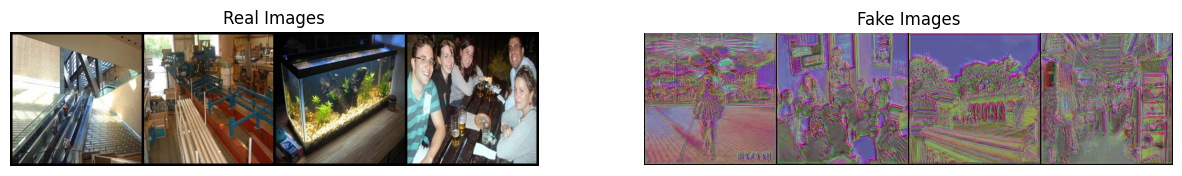

In [101]:
# Grab a batch of real images from the dataloader
real_batch = next(dl_iter)

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [27]:
test = next(dl_iter)[0]
test_mask = mask_batch(test).to(device)

In [21]:
from utils.notebook import imshow
from utils.tensor import tensor_to_numpy
from utils.image import image_from_tensor

In [115]:
test[0].shape

torch.Size([3, 256, 256])

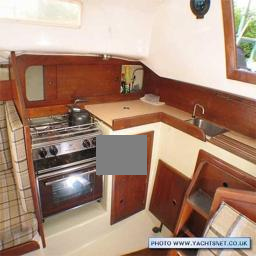

In [28]:
imshow(image_from_tensor(test_mask[0]))

In [157]:
test_mask.dtype

torch.float32

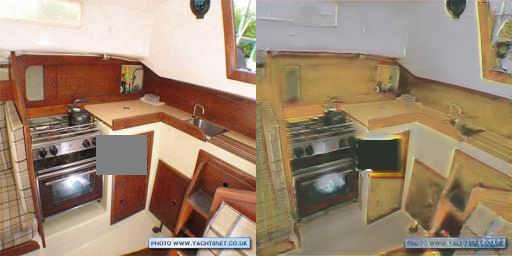

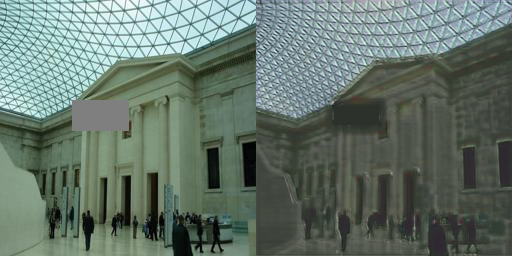

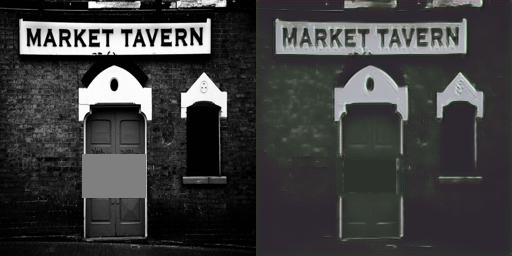

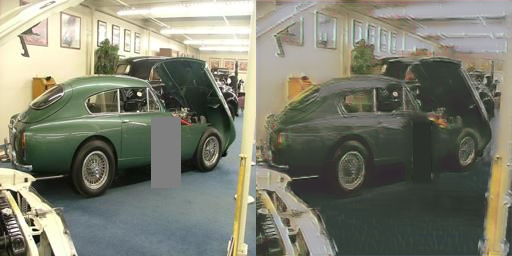

In [29]:
with torch.no_grad():
    res = netG2(test_mask)
    for i in range(batch_size):
       imshow(np.concatenate([image_from_tensor(test_mask[i]), image_from_tensor(res[i])], axis=1))


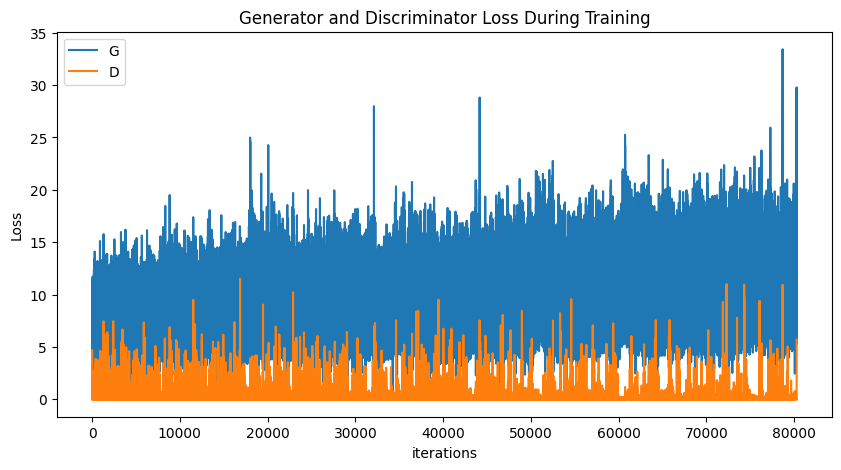

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()